In [ ]:
%%capture
!pip install qiskit[visualization]
#!pip install pycsf not working?
%pip install pyscf==1.7.5
!pip install openfermion
!pip install openfermionpyscf

In [ ]:
%%capture
import scipy
import pyscf
import openfermion
import openfermionpyscf 
import itertools
import qiskit
import numpy as np
import copy
import pickle

from google.colab import files
from openfermionpyscf import run_pyscf
from openfermion.utils import count_qubits, hermitian_conjugated
from openfermion.linalg import jw_hartree_fock_state
from openfermion.circuits import simulate_trotter
from openfermion.transforms import (
    jordan_wigner, get_fermion_operator, normal_ordered
)
from openfermion import (
    get_sparse_operator, get_ground_state, FermionOperator,
    jw_get_ground_state_at_particle_number, MolecularData,
    expectation, uccsd_convert_amplitude_format,
    get_interaction_operator, QubitOperator, eigenspectrum,
    InteractionOperator, FermionOperator
)

from qiskit import (Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, IBMQ,
                   execute, transpile)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.algorithms.optimizers import COBYLA
from qiskit.providers.ibmq import least_busy
from qiskit.test.mock import FakeBelem
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import purity
from qiskit.providers.aer.noise.device import (
    basic_device_gate_errors, gate_error_values
)
from qiskit.providers.aer.noise import (
    NoiseModel,thermal_relaxation_error, pauli_error, ReadoutError
)

from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.operators import I, Z, X, Y

import matplotlib.pyplot as plt

In [ ]:
IBMQ.enable_account("88757d22d1747c543664fb35d8789fac1c1271ff43dd365e62f067f3e34ab5c4d95f0ed7155eb5685a871a3d3b69eb34a57eece5c139b070062c8396ddc87d66")

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:
provider = IBMQ.get_provider(hub='ibm-q-minho')

## Function Definitions

In [ ]:
# Define chemical accuracy
chemicalAccuracy = 1.5936*10**-3

# Define necessary Pauli operators (two-dimensional) as matrices
pauliX = np.array([[0,1],
                 [1,0]],
                dtype = complex)
pauliZ = np.array([[1,0],
                 [0,-1]],
                dtype = complex)
pauliY = np.array([[0,-1j],
                 [1j,0]],
                dtype = complex)

def stringToMatrix(pauliString):
  '''
  Converts a Pauli string to its matrix form.

  Arguments:
    pauliString (str): the Pauli string (e.g. "IXYIZ")

  Returns:
    matrix (np.ndarray): the corresponding matrix, in the computational basis

  '''

  matrix = np.array([1])

  # Iteratively construct the matrix, going through each single qubit Pauli term
  for pauli in pauliString:
      if pauli == "I":
        matrix = np.kron(matrix,np.identity(2))
      elif pauli == "X":
        matrix = np.kron(matrix,pauliX)
      elif pauli == "Y":
        matrix = np.kron(matrix,pauliY)
      elif pauli == "Z":
        matrix = np.kron(matrix,pauliZ)

  return matrix
  
def fromVectortoKet(stateVector):
  '''
  Transforms a vector representing a basis state to the corresponding ket.

  Arguments:
    stateVector (np.ndarray): computational basis vector in the 2^n dimensional 
      Hilbert space

  Returns:
    ket (list): a list of length n representing the corresponding ket 
  '''

  dim = len(stateVector)
  ket = []

  while dim>1:
    if any (stateVector[i] for i in range(int(dim/2))):
      # Ket is of the form |0>|...>. 

      #Fix |0> as the msq.
      ket.append(0)

      # Get the vector representing the state of the remaining qubits.
      stateVector = stateVector[:int(dim/2)]

    else:
      # Ket is of the form |1>|...>. 
      
      #Fix |0> as the msq.
      ket.append(1)

      # Get the vector representing the state of the remaining qubits.
      stateVector = stateVector[int(dim//2):]

    dim = dim/2

  return ket

def fromKettoVector(ket):
  '''
  Transforms a ket representing a basis state to the corresponding state vector.

  Arguments:
    ket (list): a list of length n representing the ket 

  Returns:
    stateVector (np.ndarray): the corresponding basis vector in the 
      2^n dimensional Hilbert space
  '''
  stateVector = [1]
  
  # Iterate through the ket, calculating the tensor product of the qubit states
  for i in ket:
    qubitVector = [not i,i]
    stateVector = np.kron(stateVector,qubitVector)

  return stateVector

def slaterDeterminantToKet(index, dimension):
  '''
  Transforms a Slater Determinant (computational basis state) into
    the corresponding ket.

  Arguments:
    index (int): the index of the non-zero element of the computational
      basis state.
    dimension (int): the dimension of the Hilbert space
  
  Returns:
    ket (list): the corresponding ket as a list of length dimension
    
  '''
  
  vector = [0 for _ in range (index)]+[1]+[1 for _ in range (dimension-index-1)]
  ket = fromVectortoKet(vector)

  return ket
  
def getHartreeFockKet(electronNumber,qubitNumber):
  '''
  Get the Hartree Fock determinant, as a list in big endian representing the ket
  |1>|1>...|0>|0>.

  Arguments:
    electronNumber (int): the number of electrons of the molecule.
    qubitNumber (int): the number of qubits necessary to represent the molecule
      (equal to the number of spin orbitals we're considering active).

  Returns:
    referenceDeterminant (list): a list of lenght qubitNumber, representing the 
      ket of the adequate computational basis state in big-endian ordering.
  '''

  # Consider occupied the lower energy orbitals, until enough one particle 
  #states are filled
  referenceDeterminant = [1 for _ in range(electronNumber)]

  # Consider the remaining orbitals empty
  referenceDeterminant += [0 for _ in range(qubitNumber-electronNumber)]

  return referenceDeterminant

def calculateOverlap(stateCoordinates1,stateCoordinates2):
    '''
    Calculates the overlap between two states, given their coordinates.

    Arguments:
      stateCoordinates1 (np.ndarray): the coordinates of one of the states in 
        some orthonormal basis,
      stateCoordinates2 (np.ndarray): the coordinates of the other state, in 
        the same basis

    Returns: 
      overlap (float): the overlap between two states (absolute value of the 
        inner product).
    '''

    bra = np.conj(stateCoordinates1)
    ket = stateCoordinates2
    overlap = np.abs(np.dot(bra,ket))
    
    return overlap

def findSubStrings(mainString,hamiltonian,checked = []):
    '''
    Finds and groups all the strings in a Hamiltonian that only differ from 
    mainString by identity operators.

    Arguments:
      mainString (str): a Pauli string (e.g. "XZ)
      hamiltonian (dict): a Hamiltonian (with Pauli strings as keys and their 
        coefficients as values)
      checked (list): a list of the strings in the Hamiltonian that have already
        been inserted in another group

    Returns: 
      groupedOperators (dict): a dictionary whose keys are boolean strings 
        representing substrings of the mainString (e.g. if mainString = "XZ", 
        "IZ" would be represented as "01"). It includes all the strings in the 
        hamiltonian that can be written in this form (because they only differ 
        from mainString by identities), except for those that were in checked
        (because they are already part of another group of strings).
      checked (list):  the same list passed as an argument, with extra values
        (the strings that were grouped in this function call).
    '''
    
    groupedOperators = {}
    
    # Go through the keys in the dictionary representing the Hamiltonian that 
    #haven't been grouped yet, and find those that only differ from mainString 
    #by identities
    for pauliString in hamiltonian:
        
        if pauliString not in checked:
            # The string hasn't been grouped yet
            
            if(all((op1 == op2 or op2 == "I") \
                   for op1,op2 in zip(mainString,pauliString))):
                # The string only differs from mainString by identities
                
                # Represent the string as a substring of the main one
                booleanString = "".join([str(int(op1 == op2)) for op1,op2 in \
                                       zip(mainString,pauliString)])
                    
                # Add the boolean string representing this string as a key to 
                #the dictionary of grouped operators, and associate its 
                #coefficient as its value
                groupedOperators[booleanString] = hamiltonian[pauliString]
                
                # Mark the string as grouped, so that it's not added to any 
                #other group
                checked.append(pauliString)
                
    return (groupedOperators,checked)

def groupHamiltonian(hamiltonian):
    '''
    Organizes a Hamiltonian into groups where strings only differ from 
    identities, so that the expectation values of all the strings in each 
    group can be calculated from the same measurement array.

    Arguments: 
      hamiltonian (dict): a dictionary representing a Hamiltonian, with Pauli 
        strings as keys and their coefficients as values.

    Returns: 
      groupedHamiltonian (dict): a dictionary of subhamiltonians, each of 
        which includes Pauli strings that only differ from each other by 
        identities. 
        The keys of groupedHamiltonian are the main strings of each group: the 
        ones with least identity terms. The value associated to a main string is 
        a dictionary, whose keys are boolean strings representing substrings of 
        the respective main string (with 1 where the Pauli is the same, and 0
        where it's identity instead). The values are their coefficients.
    '''
    groupedHamiltonian = {}
    checked = []
    
    # Go through the hamiltonian, starting by the terms that have less
    #identity operators
    for mainString in \
        sorted(hamiltonian,key = lambda pauliString: pauliString.count("I")):
            
        # Call findSubStrings to find all the strings in the dictionary that 
        #only differ from mainString by identities, and organize them as a 
        #dictionary (groupedOperators)
        groupedOperators,checked = findSubStrings(mainString,hamiltonian,checked)
        
        # Use the dictionary as a value for the mainString key in the 
        #groupedHamiltonian dictionary
        groupedHamiltonian[mainString] = groupedOperators
        
        # If all the strings have been grouped, exit the for cycle
        if(len(checked) == len(hamiltonian.keys())):
           break
       
    return groupedHamiltonian

def convertHamiltonian(openfermionHamiltonian):
  '''
  Formats a qubit Hamiltonian obtained from openfermion, so that it's a suitable
  argument for functions such as measureExpectationEstimation.

  Arguments:
    openfermionHamiltonian (openfermion.qubitOperator): the Hamiltonian.

  Returns:
    formattedHamiltonian (dict): the Hamiltonian as a dictionary with Pauli
      strings (eg 'YXZI') as keys and their coefficients as values.
  '''

  formattedHamiltonian = {}
  qubitNumber = count_qubits(openfermionHamiltonian)

  # Iterate through the terms in the Hamiltonian
  for term in openfermionHamiltonian.get_operators():

    operators = []
    coefficient = list(term.terms.values())[0]
    pauliString = list(term.terms.keys())[0]
    previousQubit = -1

    for (qubit,operator) in pauliString:

      # If there are qubits in which no operations are performed, add identities 
      #as necessary, to make sure that the length of the string will match the 
      #number of qubits
      identities = (qubit-previousQubit-1)
      if identities>0: 
        operators.append('I'*identities)

      operators.append(operator)
      previousQubit = qubit
    
    # Add final identity operators if the string still doesn't have the 
    #correct length (because no operations are performed in the last qubits)
    operators.append('I'*(qubitNumber-previousQubit-1))

    formattedHamiltonian["".join(operators)] = coefficient

  return formattedHamiltonian

def hamiltonianToMatrix(hamiltonian):
    '''
    Convert a Hamiltonian (from OpenFermion) to matrix form.
    
    Arguments:
      hamiltonian (openfermion.InteractionOperator): the Hamiltonian to be
        transformed.

    Returns:
      matrix (np.ndarray): the Hamiltonian, as a matrix in the computational 
        basis
    
    ''' 
    
    qubitNumber = hamiltonian.n_qubits
    
    hamiltonian = jordan_wigner(hamiltonian)

    formattedHamiltonian = convertHamiltonian(hamiltonian)
    groupedHamiltonian = groupHamiltonian(formattedHamiltonian)

    matrix = np.zeros((2**qubitNumber,2**qubitNumber),dtype = complex)

    # Iterate through the strings in the Hamiltonian, adding the respective 
    #contribution to the matrix
    for string in groupedHamiltonian:

      for substring in groupedHamiltonian[string]:
        pauli = ("".join("I"*(not int(b)) + a*int(b) \
                         for (a,b) in zip(string,substring)))
        
        matrix += stringToMatrix(pauli) * groupedHamiltonian[string][substring]

    return matrix

def stateEnergy(stateCoordinates,hamiltonian):
    ''' 
    Calculates the exact energy in a specific state.

    Arguments:
      stateCoordinates (np.ndarray): the state in which to obtain the 
        expectation value.
      hamiltonian (dict): the Hamiltonian of the system.
    
    Returns:
      exactEnergy (float): the energy expecation value in the state.
    ''' 

    exactEnergy = 0
    
    # Obtain the theoretical expectation value for each Pauli string in the
    #Hamiltonian by matrix multiplication, and perform the necessary weighed
    #sum to obtain the energy expectation value.
    for pauliString in hamiltonian:
        
        ket = np.array(stateCoordinates,dtype = complex)
        bra = np.conj(ket)
        
        ket = np.matmul(stringToMatrix(pauliString),ket)
        expectationValue = np.real(np.dot(bra,ket))
        
        exactEnergy+=\
            hamiltonian[pauliString]*expectationValue
            
    return exactEnergy

def exactStateEnergySparse(stateVector,sparseHamiltonian):
    ''' 
    Calculates the exact energy in a specific state, using sparse matrices.

    Arguments:
      stateVector (Union[np.ndarray, scipy.sparse.csc_matrix): the state in 
        which to obtain the expectation value.
      sparseHamiltonian (scipy.sparse.csc_matrix): the Hamiltonian of the system.
    
    Returns:
      energy (float): the energy expecation value in the state.
    ''' 

    if not isinstance(stateVector,scipy.sparse.csc_matrix):
      ket = scipy.sparse.csc_matrix(stateVector,dtype=complex).transpose()
    else:
      ket = stateVector
      
    bra = ket.transpose().conj()

    energy = (bra * sparseHamiltonian * ket)[0,0].real
    
    return energy

def pauliToCircuit(operator,parameter,circuit,qubitNumber): 
  '''
  Creates the circuit for applying e^ (j * operator * parameter), for 'operator'
  a single Pauli string.
  Uses little endian endian, as Qiskit requires.

  Arguments:
    operator (union[openfermion.QubitOperator, openfermion.FermionOperator,
      openfermion.InteractionOperator]): the operator to be simulated
    parameter (qiskit.circuit.parameter): the variational parameter
    circuit (qiskit.circuit.QuantumCircuit): the circuit to add the gates to
    qubitNumber (int): the number of qubits in the circuit
  '''

  # If operator is an InteractionOperator, shape it into a FermionOperator
  if isinstance(operator,InteractionOperator):
    operator = get_fermion_operator(operator)

  # If operator is a FermionOperator, use the Jordan Wigner transformation
  #to map it into a QubitOperator
  if isinstance(operator,FermionOperator):
    operator = jordan_wigner(operator)

  # Isolate the Pauli string (term should only have one)
  pauliString = list(operator.terms.keys())[0]

  # Keep track of the qubit indices involved in this particular Pauli string.
  # It's necessary so as to know which are included in the sequence of CNOTs 
  #that compute the parity
  involvedQubits = []

  # Perform necessary basis rotations
  for pauli in pauliString:

    # Get the index of the qubit this Pauli operator acts on
    qubitIndex = pauli[0]
    involvedQubits.append(qubitIndex)

    # Get the Pauli operator identifier (X,Y or Z)
    pauliOp = pauli[1]

    if pauliOp == "X":
      # Rotate to X basis
      # In big endian the argument would be qubitIndex
      circuit.h(qubitNumber - 1 - qubitIndex)

    if pauliOp == "Y":
      # Rotate to Y Basis
      circuit.rx(np.pi/2,qubitNumber - 1 - qubitIndex)

  # Compute parity and store the result on the last involved qubit
  for i in range(len(involvedQubits)-1):

    control = involvedQubits[i]
    target = involvedQubits[i+1]

    circuit.cx(qubitNumber - 1 - control,qubitNumber - 1 - target)
  
  # Apply e^(i*Z*parameter) = Rz(-parameter*2) to the last involved qubit
  lastQubit = max(involvedQubits)
  circuit.rz(-2 * parameter,qubitNumber - 1 - lastQubit)

  # Uncompute parity
  for i in range(len(involvedQubits)-2,-1,-1):

    control = involvedQubits[i]
    target = involvedQubits[i+1]

    circuit.cx(qubitNumber - 1 - control,qubitNumber - 1 - target)

  # Undo basis rotations
  for pauli in pauliString:

    # Get the index of the qubit this Pauli operator acts on
    qubitIndex = pauli[0]

    # Get the Pauli operator identifier (X,Y or Z)
    pauliOp = pauli[1]

    if pauliOp == "X":
      # Rotate to Z basis from X basis
      circuit.h(qubitNumber - 1 - qubitIndex)

    if pauliOp == "Y":
      # Rotate to Z basis from Y Basis
      circuit.rx(-np.pi/2,qubitNumber - 1 - qubitIndex)

def toAquaObservable(operator):
  observable = 0

  for pauliString in operator:

    transformedPauli = 1
    for pauli in pauliString:
      if pauli == "I":
        transformedPauli = transformedPauli ^ I
      elif pauli == "X":
        transformedPauli = transformedPauli ^ X
      elif pauli == "Y":
        transformedPauli = transformedPauli ^ Y
      elif pauli == "Z":
        transformedPauli = transformedPauli ^ Z


    coefficient = operator[pauliString]
    observable += transformedPauli * coefficient

  return observable

## Molecule Definitions

In [ ]:
# H2
geometry = [['H',[0,0,0]],['H',[0,0,0.74]]]
basis = 'sto-3g'
multiplicity = 1
charge = 0
h2 = MolecularData(geometry,basis,multiplicity,charge,description='H2')
h2m = run_pyscf(h2,run_fci = True,run_ccsd = True)

# HeH+
r = 1 # interatomic distance in angstrom
geometry = [['He',[0,0,0]],['H',[0,0,r]]]
basis = 'sto-3g'
multiplicity = 1
charge = +1
helonium = MolecularData(geometry,basis,multiplicity,charge,description='HeH+')
helonium = run_pyscf(helonium,run_fci = True,run_ccsd = True)

# LiH
bondLength = 1.45 # interatomic distance in angstrom
geometry = [['Li',[0,0,0]],['H',[0,0,bondLength]]]
basis = 'sto-3g'
multiplicity = 1
charge = 0
liH = MolecularData(geometry,basis,multiplicity,charge,description='LiH')
liH = run_pyscf(liH,run_fci = True,run_ccsd = True)

# Alternative to using run_pyscf: load from OpenFermion (data for this 
#particular molecule at this particular interatomic distance is available in 
#a file that comes with OF)
liHOF = MolecularData(geometry,basis,multiplicity,charge,description = '1.45')
liHOF.load()

# H4
r = 1.5
geometry = [('H', (0,0,0)), ('H', (0,0,r)), ('H', (0,0,2*r)), 
            ('H', (0,0,3*r))]
basis = 'sto-3g'
multiplicity = 1
charge = 0
h4 = MolecularData(geometry,basis,multiplicity,charge,description='H4')
h4 = run_pyscf(h4,run_fci = True,run_ccsd = True)

# H6
r = 1.5
geometry = [('H', (0,0,0)), ('H', (0,0,r)), ('H', (0,0,2*r)), 
            ('H', (0,0,3*r)), ('H', (0,0,4*r)), ('H', (0,0,5*r))]
basis = 'sto-3g'
multiplicity = 1
charge = 0
h6 = MolecularData(geometry,basis,multiplicity,charge,description='H6')
h6 = run_pyscf(h6,run_fci = True,run_ccsd = True)

## Choosing the Molecule

In [ ]:
molecule = h2
exactEnergy = molecule.fci_energy

In [ ]:
name = molecule.description
bondLength = molecule.geometry[1][1][2]

qubitNumber = molecule.n_qubits
electronNumber = molecule.n_electrons
orbitalNumber = molecule.n_orbitals

## Defining the Operator Pool

Code for creating the fermionic pool (singlet_gsd) taken from [the GitHub repository with the original Adapt-VQE implementation](https://github.com/mayhallgroup/adapt-vqe).

In [ ]:
singlet_gsd = []

for p in range(0,orbitalNumber):
    pa = 2*p
    pb = 2*p+1

    for q in range(p,orbitalNumber):
        qa = 2*q
        qb = 2*q+1

        termA =  FermionOperator(((pa,1),(qa,0)))
        termA += FermionOperator(((pb,1),(qb,0)))

        termA -= hermitian_conjugated(termA)
        termA = normal_ordered(termA)

        #Normalize
        coeffA = 0
        for t in termA.terms:
            coeff_t = termA.terms[t]
            coeffA += coeff_t * coeff_t

        if termA.many_body_order() > 0:
            termA = termA/np.sqrt(coeffA)
            singlet_gsd.append(termA)


pq = -1
for p in range(0,orbitalNumber):
    pa = 2*p
    pb = 2*p+1

    for q in range(p,orbitalNumber):
        qa = 2*q
        qb = 2*q+1

        pq += 1

        rs = -1
        for r in range(0,orbitalNumber):
            ra = 2*r
            rb = 2*r+1

            for s in range(r,orbitalNumber):
                sa = 2*s
                sb = 2*s+1

                rs += 1

                if(pq > rs):
                    continue

                termA =  FermionOperator(((ra,1),(pa,0),(sa,1),(qa,0)), 2/np.sqrt(12))
                termA += FermionOperator(((rb,1),(pb,0),(sb,1),(qb,0)), 2/np.sqrt(12))
                termA += FermionOperator(((ra,1),(pa,0),(sb,1),(qb,0)), 1/np.sqrt(12))
                termA += FermionOperator(((rb,1),(pb,0),(sa,1),(qa,0)), 1/np.sqrt(12))
                termA += FermionOperator(((ra,1),(pb,0),(sb,1),(qa,0)), 1/np.sqrt(12))
                termA += FermionOperator(((rb,1),(pa,0),(sa,1),(qb,0)), 1/np.sqrt(12))

                termB =  FermionOperator(((ra,1),(pa,0),(sb,1),(qb,0)),  1/2.0)
                termB += FermionOperator(((rb,1),(pb,0),(sa,1),(qa,0)),  1/2.0)
                termB += FermionOperator(((ra,1),(pb,0),(sb,1),(qa,0)), -1/2.0)
                termB += FermionOperator(((rb,1),(pa,0),(sa,1),(qb,0)), -1/2.0)

                termA -= hermitian_conjugated(termA)
                termB -= hermitian_conjugated(termB)

                termA = normal_ordered(termA)
                termB = normal_ordered(termB)

                #Normalize
                coeffA = 0
                coeffB = 0
                for t in termA.terms:
                    coeff_t = termA.terms[t]
                    coeffA += coeff_t * coeff_t
                for t in termB.terms:
                    coeff_t = termB.terms[t]
                    coeffB += coeff_t * coeff_t


                if termA.many_body_order() > 0:
                    termA = termA/np.sqrt(coeffA)
                    singlet_gsd.append(termA)

                if termB.many_body_order() > 0:
                    termB = termB/np.sqrt(coeffB)
                    singlet_gsd.append(termB)

print("Pool size:",len(singlet_gsd))

Pool size: 4


In [ ]:
pool = singlet_gsd

qubitPool = []

for fermionOp in pool:

  qubitOp = jordan_wigner(fermionOp)
  
  for pauli in qubitOp.terms:

    qubitOp = QubitOperator(pauli,1j)

    if qubitOp not in qubitPool:
      qubitPool.append(qubitOp)

print("Pool Size:",len(qubitPool))

Pool Size: 20


## AdaptData class

In [ ]:
class AdaptData:
  '''
  Class meant to store data from an Adapt VQE run. 

  Methods:
    processIteration: to be called by the AdaptVQE class at the end of each 
      iteration
    close: to be called by the AdaptVQE class at the end of the run
    plot: to be called to plot data after the run 
  '''

  def __init__(self,
               initialEnergy,
               pool,
               sparsePool,
               referenceDeterminant,
               backend,
               shots,
               previousData = None):
    '''
    Initialize class instance

    Arguments:
      initialEnergy (float): energy of the reference state
      pool (list): operator pool
      sparsePool (list): sparse version of the pool
      referenceDeterminant (list): the Slater determinant to be used as reference,
        in big endian ordering (|abcd> <-> [a,b,c,d]; [qubit 0, qubit 1,...])
      backend (Union[None,qiskit.providers.ibmq.IBMQBackend]): the backend to 
        be used. If none, a simulation will be run using sparse matrices.
      shots (int): number of circuit repetitions
      previousData (AdaptData): data from a previous run, to be used as a 
        starting point
    '''

    self.pool = pool
    self.sparsePool = sparsePool
    self.backend = qinstance.backend
    self.shots = shots
    
    if previousData is not None:
      # Starting point is the result of a previous Adapt run

      self.initialEnergy = initialEnergy
      self.evolution = copy.deepcopy(previousData.evolution)

      # Make sure the data corresponds to a complete run
      if not previousData.result:
        raise ValueError("Previous data does not supply final results.")

      self.current = copy.deepcopy(previousData.result)
      self.iterationCounter = previousData.iterationCounter

      # Make sure we're using the same pool
      # Comparing lenght is good enough
      if previousData is not None:
        assert(len(self.sparsePool) == len(previousData.sparsePool))

      '''
      assert(self.iterationCounter == len(self.evolution["selected gradient"]))
      assert(self.iterationCounter == len(self.evolution["total norm""]))
      assert(self.iterationCounter == len(self.evolution["coefficients"]))
      assert(self.iterationCounter == len(self.current["ansatz"]))
      assert(self.iterationCounter == len(self.current["coefficients"]))
      assert(self.iterationCounter == len(self.current["indices"]))
      '''

    else:
      # The initial energy is stored apart from the remaining ones, so that the 
      #index of the gradient norms in the beginning of each iteration 
      #corresponds to the index of the coefficients and energies in that 
      #iteration in the respective arrays.
      self.initialEnergy = initialEnergy

      self.evolution = {}
      self.evolution["energies"] = []
      self.evolution["total norm"] = []
      self.evolution["selected gradient"] = []
      self.evolution["coefficients"] = []
      self.evolution["energyChange"] = []
      self.evolution["indices"] = []

      self.current = {}
      self.current["ansatz"] = []
      self.current["coefficients"] = []
      self.current["indices"] = []
      # performance of a selected operator = | energy change / gradient | 
      self.current["ansatz performances"] = []
      self.current["performances"] = []
      self.current["energy"] = None
      self.current["state"] = None
      self.current["total norm"] = None

      self.iterationCounter = 0

    self.closed = False
    self.success = False

    assert(self.iterationCounter == len(self.evolution["selected gradient"]))
    assert(self.iterationCounter == len(self.evolution["total norm"]))
    assert(self.iterationCounter == len(self.evolution["coefficients"]))
 
    self.result = {}

  def processIteration(self,
                   operatorIndex,
                   operator,
                   energy,
                   totalNorm,
                   selectedGradient,
                   coefficients):
    '''
    Receives and processes the values fed to it by an instance of the AdaptVQE 
    class at the end of each run.

    Arguments:
      operatorIndex (int): index of the selected operator
      operator (union[openfermion.QubitOperator, openfermion.FermionOperator]):
        the selected operator
      energy (float): the optimized energy, at the end of the iteration
      totalNorm (int): the norm of the total gradient norm at the beggining 
        of this iteration
      selectedGradient (float): the absolute value of the gradient of the 
        operator that was added in this iteration
      coefficients (list): a list of the coefficients selected by the optimizer
        in this iteration
    '''

    if not isinstance(energy,float):
      raise TypeError("Expected float, not {}.".format(type(energy).__name__))
    if not isinstance(totalNorm,float):
      raise TypeError("Expected float, not {}.".format(type(totalNorm).__name__))
    if not isinstance(selectedGradient,float):
      raise TypeError("Expected float, not {}.".format(type(selectedGradient).__name__))
    if not isinstance(coefficients,list):
      raise TypeError("Expected list, not {}.".format(type(coefficients).__name__))

    if len(coefficients) != len(self.current["ansatz"]) + 1:
      raise ValueError("The length of the coefficient list should match the"
      " ansatz size ({} != {}).".format
        (len(coefficients),len(self.current["ansatz"]) + 1))

    if totalNorm < 0:
      raise ValueError("Total gradient norm should be positive; its {}".\
                       format(totalNorm))
      
    self.current["coefficients"] = copy.deepcopy(coefficients)
    
    if self.iterationCounter == 0:
      previousEnergy = self.initialEnergy
    else:
      previousEnergy = self.current["energy"] 

    energyChange = energy - previousEnergy
    performance = np.abs(energyChange / selectedGradient)

    self.current["ansatz performances"].append(performance)
    self.current["performances"].append(performance)

    ansatzPerformance = np.average(self.current["ansatz performances"])

    print("Energy Change: ",energyChange)
    print("Performance ratio: ",performance)
    print("\nCurrent average performance ratio: ", 
          np.average(self.current["performances"]))
    print("Current 10-last average performance ratio: ", 
          np.average(self.current["performances"][-10:]))
    print("Current average performance ratio of the ansatz: ",
          ansatzPerformance)

    self.current["ansatz"].append(operator)
    self.current["energy"] = energy
    self.current["indices"].append(operatorIndex)
    self.current["total norm"] = totalNorm

    coefficientCopy = copy.deepcopy(self.current["coefficients"])
    indicesCopy = copy.deepcopy(self.current["indices"])

    self.evolution["energies"].append(energy)
    self.evolution["energyChange"].append(energyChange)
    self.evolution["total norm"].append(totalNorm)
    self.evolution["selected gradient"].append(selectedGradient)
    self.evolution["indices"].append(indicesCopy) 

    self.evolution["coefficients"].append(coefficientCopy)

    self.iterationCounter += 1

    #assert(self.iterationCounter == len(self.evolution["total norm"]))
    #assert(self.iterationCounter == len(self.evolution["coefficients"]))
    #assert(self.iterationCounter == len(self.evolution["energies"]))

  def close(self,success):
    '''
    To be called at the end of the run, to close the data structures

    Arguments:
      success (bool): True if the convergence condition was met, False if not
        (the maximum number of iterations was met before that)
    '''

    self.result = self.current
    self.closed = True
    self.success = success

  def plot(self, plotGradient = True, detailedTitle = True):
    '''
    Plots the evolution of the energy along the run.

    Arguments:
      plotGradient (bool): whether the total gradient norm should be plotted 
        as well.
      detailedTitle (bool): whether the title should have include which was the
        used backend and the shot number.
    '''

    iterationNumber = self.iterationCounter
    iterationLabels = [iterationLable 
                      for iterationLable in range(0,self.iterationCounter+1)]


    gradientNorms = self.evolution["total norm"]
    energies = [self.initialEnergy] + self.evolution["energies"]

    fig, ax1 = plt.subplots(figsize=[8,8])
    title = "Qubit Adapt VQE for {}".format(molecule.description)

    if self.backend is None:
      backendName = None

    elif self.backend.name() == "statevector_simulator":
      backendName = "Aer State Vector Simulator"

    elif self.backend.name() == "qasm_simulator":
      backendName = "Aer QASM Simulator"

    else:
      backendName = self.backend.name()

    if detailedTitle:
      title += "\nr = {}Å".format(str(bondLength))
      if backendName is not None:
        title += ", {}".format(backendName)
      if backendName != "Aer State Vector Simulator":
        title += ", {} shots".format(self.shots)

    plt.title(title)

    color1 = 'b'  
    ax1.plot(iterationLabels, energies, '--o',color = color1)
    ax1.tick_params(axis='y', labelcolor = color1)

    # Shade area within chemical accuracy
    exactEnergy = molecule.fci_energy
    minAccuracy = exactEnergy - chemicalAccuracy
    maxAccuracy = exactEnergy + chemicalAccuracy
    l = ax1.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

    ax1.set_xlabel("Iteration Number")
    ax1.set_ylabel("Energy (au)",color = color1)
    
    plt.xticks(range(1, 1 + self.iterationCounter))

    if plotGradient:
      color2 = 'r'
      ax2 = ax1.twinx()
      ax2.plot(iterationLabels[1:], gradientNorms, '--o',color = color2)
      ax2.tick_params(axis='y', labelcolor = color2)
      ax2.set_ylabel("Total Gradient Norm",color = color2)

## AdaptVQE Class

In [ ]:
class AdaptVQE:
  '''
  Class for running the VQE algorithm.

  Methods:
    prepare: to be called before the run, in order to prepare the sparse pool
      and possibly upload previous data
    printSettings: print the algorithm options
    computeState: calculate the state with the current ansatz and coefficients
    calculateOperatorGradient: calculate the absolute vale of the gradient of 
      a given operator
    selectOperator: select the operator to be added to the ansatz
    calculateEnergy: calculate the energy with a certain ansatz and coefficients
    callback: store intermediate data from the optimization
    optimizeCircuit: optimize a parametrized circuit with a given ansatz
    run: run the algorithm
  '''

  def __init__(self,
               pool,
               molecule,
               qinstance,
               referenceDeterminant = None,
               verbose = False,
               maxIterations = 50,
               threshold = 0.1,
               shots = 1000):
    '''
    Initialize class instance

    Arguments:
      pool (list): operator pool
      molecule (openfermion.MolecularData): the molecule we're finding the 
        ground state of
      referenceDeterminant (list): the Slater determinant to be used as reference,
        in big endian ordering (|abcd> <-> [a,b,c,d]; [qubit 0, qubit 1,...]).
        If none, the Hartree Fock determinant will be used.
      verbose (bool): whether to print all the non-zero gradients, or to just
        leave out that information
      maxIterations (int): maximum allowed number of iterations until forcing
        a stop, even if the convergence threshold isn't met
      threshold (float): the convergence threshold. When the total gradient norm
        is lower than this, the algorithm will stop
      backend (Union[None,qiskit.providers.ibmq.IBMQBackend]): the backend to 
        be used. If none, a simulation will be run using sparse matrices.
      shots (int): number of circuit repetitions
    '''
    self.pool = pool.copy()
    self.molecule = molecule
    self.verbose = verbose

    self.referenceDeterminant = referenceDeterminant
    self.electronNumber = molecule.n_electrons
    self.hamiltonian = molecule.get_molecular_hamiltonian()
    self.qubitNumber = self.hamiltonian.n_qubits
    self.sparseHamiltonian = get_sparse_operator(self.hamiltonian,self.qubitNumber)
    self.qubitHamiltonian = jordan_wigner(self.hamiltonian)
    
    dictHamiltonian = convertHamiltonian(self.qubitHamiltonian)
    self.aquaObservable = toAquaObservable(dictHamiltonian)
  
    # Format and group the Hamiltonian, so as to save measurements in the 
    #circuit simulation by using the same data for Pauli strings that only 
    #differ by identities
    self.formattedHamiltonian = convertHamiltonian(self.qubitHamiltonian)
    self.groupedHamiltonian = groupHamiltonian(self.formattedHamiltonian)

    self.maxIterations = maxIterations
    self.threshold = threshold

    self.backend = backend
    self.shots = shots

    self.sparsePool = []
    self.ansatz = []
    self.coefficients = []
    self.indices = []

  def prepare(self,
              sparsePool = None,
              previousData = None):
    '''
    Prepare to run the algorithm

    Arguments:
      sparsePool (list): a sparse version of the pool, to avoid reobtaining 
        sparse versions of the operators if they've already been obtained
      previousData (AdaptData): data from a previous run, that will be continued
      
    '''
    # If they weren't provided, obtain sparse versions of the operators to 
    #avoid constantly recalculating them
    if sparsePool is None:
      print("Sparse version of the pool was not provided. Obtaining it...")

      for operator in self.pool:
        self.sparsePool.append(get_sparse_operator(operator,self.qubitNumber))

    else:
      self.sparsePool = sparsePool

    print("Initializing data structures...")

    if self.referenceDeterminant is None:
      # Set the Hartree Fock state as reference
      self.referenceDeterminant = getHartreeFockKet(self.electronNumber,self.qubitNumber)

    print("\nAdapt VQE prepared with the following settings:")
    self.printSettings()
    self.referenceState = fromKettoVector(self.referenceDeterminant)

    self.sparseReferenceState = scipy.sparse.csc_matrix(
        self.referenceState,dtype=complex
        ).transpose()

    # Calculate energy of the reference state.
    initialEnergy = self.calculateEnergy([],[])

    # Initialize insance of AdaptData class that will store the data from the 
    #run
    self.data = AdaptData(initialEnergy,
                          self.pool,
                          self.sparsePool,
                          self.referenceDeterminant,
                          self.backend,
                          self.shots,
                          previousData)
        
    if self.data.current["state"] is None:
      # There's no previous data; initialize state at reference
      self.data.current["state"] = self.sparseReferenceState
    
  def printSettings(self):
      '''
      Prints the options that were chosen for the Adapt VQE run.
      '''

      print("> Convergence threshold (gradient norm): ", self.threshold)
      print("> Maximum number of iterations: ", self.maxIterations)
      print("> Backend: ",self.backend)
      if self.backend is None:
        print("(using sparse matrices)")
      elif backend.name() != "statevector_simulator":
        print("(Shot number: {})".format(self.shots))

  def computeState(self):
    '''
      Calculates the state with the current ansatz and coefficients.

      Returns:
        state (scipy.sparse.csc_matrix): the state
    '''

    # Since the coefficients are reoptimized every iteration, the state has to 
    #be built from the reference state each time.

    # Initialize the state vector with the reference state.
    state = self.sparseReferenceState

    # Apply the ansatz operators one by one to obtain the state as optimized
    #by the last iteration
    for (i,operatorIndex) in enumerate(self.data.current["indices"]):

      # Obtain the exponentiated pool operator, multiplied by the respective
      #variational parameter (as optimized by the last iteration)
      coefficient = self.data.current["coefficients"][i]
      sparseOperator = self.sparsePool[operatorIndex].multiply(coefficient)
      expOperator = scipy.sparse.linalg.expm(sparseOperator)

      # Act on the state with the operator 
      state = expOperator * state

    return state

  def calculateOperatorGradient(self,operatorIndex):
    '''
      Calculates the gradient of a given operator in the current state.
      Uses dexp(c*A)/dc = <psi|[H,A]|psi> = 2 * real(<psi|HA|psi>).
      This is the gradient calculated at c = 0, which will be the initial value 
      of the coefficient in the optimization.

      Arguments:
        operatorIndex (int): the index that labels this operator
      
      Returns:
        gradient (float): the norm of the gradient of this operator in the 
          current state
    '''

    sparseOperator = self.sparsePool[operatorIndex]
    currentState = self.data.current["state"]

    testState = sparseOperator * currentState
    bra = currentState.transpose().conj()

    gradient = 2 * (np.abs(bra * self.sparseHamiltonian * testState)[0,0].real)

    return gradient
  
  def selectOperator(self):
    ''' 
    Choose the next operator to be added to the ansatz, using as criterion
    that the one with the maximum gradient norm is the selected one.

    Returns:
      selectedIndex (int): the index that labels the selected operator
      selectedGradient (float): the norm of the gradient of that operator
      totalNorm (float): the total gradient norm
    '''

    selectedGradient = 0
    selectedIndex = None
    totalNorm = 0

    print("Calculating gradients and selecting the next operator...")
    
    if self.verbose:
      print("\nNon-Zero Gradients (calculated, tolerance E-5):")

    for operatorIndex in range(len(self.pool)):

      gradient = self.calculateOperatorGradient(operatorIndex)

      totalNorm += gradient**2

      if self.verbose:
        if gradient > 10**-5:
          print("Operator {}: {}".format(operatorIndex,gradient))

      if gradient > selectedGradient:
        selectedIndex = operatorIndex
        selectedGradient = gradient

    totalNorm = np.sqrt(totalNorm)
    
    print("Total gradient norm: {}".format(totalNorm))

    return selectedIndex, selectedGradient, totalNorm

  def calculateEnergy(self,coefficients,indices):
    '''
    Calculates the energy in a specified state.

    Arguments:
      coefficients (list): coefficients of the ansatz indices
      indices (list): indices that specify which operators are in the ansatz.

    Returns:
      energy (float): the energy in this state.
    '''

    assert(len(coefficients) == len(indices))
    
    ket = self.sparseReferenceState

    # Apply e ** (coefficient * operator) to the state (ket) for each operator in 
    #the ansatz, following the order of the list
    for (coefficient,operatorIndex) in zip(coefficients,indices):

      # Multiply the operator by the respective coefficient
      sparseOperator = coefficient * self.sparsePool[operatorIndex]

      # Exponentiate the operator and update ket to represent the state after
      #this operator has been applied
      expOperator = scipy.sparse.linalg.expm(sparseOperator)
      ket = expOperator * ket

    # Get the corresponding bra and calculate the energy: |<bra| H |ket>|
    bra = ket.transpose().conj()
    energy = (bra * self.sparseHamiltonian * ket)[0,0].real

    return energy

  def callback(self, nfev, parameters, energy, stddev):
    '''
    Function to gather intermediate data from the optimization. Fills the 
    instance variable optEvolution with the data from each step in the 
    optimization process.
    '''

    self.optEvolution['nfev'].append(nfev)
    self.optEvolution['parameters'].append(parameters.copy())
    self.optEvolution['energy'].append(energy)
    self.optEvolution['stddev'].append(stddev)
        
  def optimizeCircuit(self,initialCoefficients,indices):
    '''
    Optimizes a certain ansatz, filling the instance variable optEvolution 
      with the optimization data.

    Arguments:
      initialCoefficients (list): the coefficients that define the starting 
        point.
      indices (list): the indices that identify the ansatz to be optimized
    '''
    
    # Initialize instance variable, that will be filled with the data from this 
    #optimization. The data from the previous one will be deleted.
    self.optEvolution = {
        'nfev': [],
        'parameters': [],
        'energy': [],
        'stddev': []
    }

    # Initialize parameter vector and circuit in Qiskit
    parameters = ParameterVector("Params",len(indices))
    ansatz = QuantumCircuit(self.qubitNumber)

    # Apply gates that prepare the reference determinant
    for i,state in enumerate(self.referenceDeterminant):
      if state == 1:
        ansatz.x(self.qubitNumber - 1 - i)

    # Apply gates corresponding to each of the ansatz operators.
    for i, op in enumerate(indices):
      pauliToCircuit(self.pool[op],
                      parameters[i],
                      ansatz,
                      self.qubitNumber)

    vqe = VQE(self.aquaObservable,
              var_form = ansatz, 
              optimizer = COBYLA(rhobeg = 0.1), 
              quantum_instance = qinstance,
              callback = self.callback,
              initial_point = initialCoefficients)

    result = vqe.run()

  def run(self):
    '''
    Run the full Adapt VQE algorithm, until either the convergence condition is
      met or the maximum number of iterations is reached.
    '''

    while self.data.iterationCounter < self.maxIterations:

      print("\n*** Adapt Iteration {} ***\n".format
            (self.data.iterationCounter + 1))

      maxIndex, maxGradient, totalNorm = self.selectOperator()
      maxOperator = self.pool[maxIndex]

      if totalNorm < self.threshold:

        print("\nConvergence condition achieved!\n")
        self.data.close(success = True)

        if self.data.result["energy"] is None:
          print("The chosen threshold was too large;" 
                " no iterations were completed.")
          return

        print("Final Energy:", self.data.result["energy"])
        error = self.data.result["energy"] - molecule.fci_energy
        print("Error:",error)
        print("(in % of chemical accuracy: {:.3f}%)\n".format
              (error/chemicalAccuracy*100))
        
        print("Ansatz Indices:", self.data.result["indices"])
        print("Coefficients:", self.data.result["coefficients"])

        return

      print("Selected: {}, index {}".format(self.pool[maxIndex],maxIndex))

      print("(gradient: {})".format(maxGradient))

      newIndices = self.data.current["indices"].copy()
      newIndices.append(maxIndex)

      # Initialize the coefficient of the operator that will be newly added at 0
      newCoefficients = copy.deepcopy(self.data.current["coefficients"])
      newCoefficients.append(0)

      print("\nOptimizing energy with indices {}...".format
            (self.data.current["indices"] + [maxIndex]))
      indices = self.data.current["indices"] + [maxIndex]

      if self.backend is None:
        # Use sparse matrices
        opt_result = scipy.optimize.minimize(self.calculateEnergy, 
                                            newCoefficients,
                                            indices,
                                            method = "COBYLA",
                                            #tol = 10**-4,
                                            options = {'rhobeg': 0.1,
                                                        'disp': True})
        optimizedCoefficients = list(opt_result.x)
        nfev = opt_result.nfev

      else:
        # Optimize the ansatz in Qiskit
        self.optimizeCircuit(newCoefficients,indices)

        evolution = self.optEvolution
        optimizedCoefficients = list(self.optEvolution["parameters"][-1])
        nfev = self.optEvolution["nfev"][-1]
        
      optimizedEnergy = self.calculateEnergy(optimizedCoefficients,
                                             indices)
      
      print("Number of function evaluations:",nfev)
      print("Optimized energy: ",optimizedEnergy)
      print("Optimized coefficients: ", optimizedCoefficients)
        
      self.data.processIteration(maxIndex,
                             maxOperator,
                             optimizedEnergy,
                             totalNorm,
                             maxGradient,
                             optimizedCoefficients)
      
      print("Current ansatz:", self.data.current["ansatz"])
      
      # Update current state
      newState = self.computeState()
      self.data.current["state"] = newState
      
      print("\nEnergy Changes Associated with the Indices:",
            self.data.evolution["energyChange"])
      print("Performances Associated with the Indices: ",
            self.data.current["ansatz performances"])
    
    print("\nThe maximum number of iterations ({}) was hit before the"
    " convergence criterion was satisfied.\n"
    "(current gradient norm is {} > {})"
    .format(self.maxIterations,self.data.current["total norm"],self.threshold))
    self.data.close(success = False)


## Noise Model

### Backend noise models

In [ ]:
# Noise model from ibmq_belem

device_backend = FakeBelem()
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map

belemNM = NoiseModel.from_backend(device)
basis_gates = belemNM.basis_gates

In [ ]:
config = device_backend.configuration()
props = device_backend.properties()
gateErrors = basic_device_gate_errors(props,thermal_relaxation = False)

import pprint
pprint.pprint(gateErrors)
print(gate_error_values(props))

[('id',
  [0],
  QuantumError([([{'name': 'x', 'qubits': [0]}], 0.00011539193832914837), ([{'name': 'y', 'qubits': [0]}], 0.00011539193832914837), ([{'name': 'z', 'qubits': [0]}], 0.00011539193832914837), ([{'name': 'id', 'qubits': [0]}], 0.9996538241850126)])),
 ('id',
  [1],
  QuantumError([([{'name': 'x', 'qubits': [0]}], 0.0002055442092625086), ([{'name': 'y', 'qubits': [0]}], 0.0002055442092625086), ([{'name': 'z', 'qubits': [0]}], 0.0002055442092625086), ([{'name': 'id', 'qubits': [0]}], 0.9993833673722124)])),
 ('id',
  [2],
  QuantumError([([{'name': 'x', 'qubits': [0]}], 0.0001484837519483761), ([{'name': 'y', 'qubits': [0]}], 0.0001484837519483761), ([{'name': 'z', 'qubits': [0]}], 0.0001484837519483761), ([{'name': 'id', 'qubits': [0]}], 0.9995545487441548)])),
 ('id',
  [3],
  QuantumError([([{'name': 'x', 'qubits': [0]}], 0.0003365184216466817), ([{'name': 'y', 'qubits': [0]}], 0.0003365184216466817), ([{'name': 'z', 'qubits': [0]}], 0.0003365184216466817), ([{'name': 'id'

### Isolate noise from different operations

In [ ]:
# Isolate noise (from the backend model) associated with each type of gates

noiseDict = belemNM.to_dict()

measNoiseDict = {}
resetNoiseDict = {}
idNoiseDict = {}
sxNoiseDict = {}
xNoiseDict = {}
cxNoiseDict = {}

measNoiseDict["errors"] = []
resetNoiseDict["errors"] = []
idNoiseDict["errors"] = []
sxNoiseDict["errors"] = []
xNoiseDict["errors"] = []
cxNoiseDict["errors"] = []

cxMeasNoiseDict = {}
cxMeasNoiseDict["errors"] = []

# Add to the new noise model the desired errors from the ibmq_belem noise model.
for error in noiseDict["errors"]:
  #print(error["type"],error["operations"])
  # error["operations"][0] is one of ["measure","reset","id","sx","x","cx"]

  if error["operations"][0] == "measure":
    measNoiseDict["errors"].append(error)
  if error["operations"][0] == "reset":
    resetNoiseDict["errors"].append(error)
  if error["operations"][0] == "id":
    idNoiseDict["errors"].append(error)
  if error["operations"][0] == "sx":
    sxNoiseDict["errors"].append(error)
  if error["operations"][0] == "x":
    xNoiseDict["errors"].append(error)
  if error["operations"][0] == "cx":
    cxNoiseDict["errors"].append(error)

  if error["operations"][0] in ["cx","measure"]:
    cxMeasNoiseDict["errors"].append(error)

measNoiseModel = NoiseModel(basis_gates=belemNM.basis_gates)
resetNoiseModel = NoiseModel(basis_gates=belemNM.basis_gates)
idNoiseModel = NoiseModel(basis_gates=belemNM.basis_gates)
sxNoiseModel = NoiseModel(basis_gates=belemNM.basis_gates)
xNoiseModel = NoiseModel(basis_gates=belemNM.basis_gates)
cxNoiseModel = NoiseModel(basis_gates=belemNM.basis_gates)

measNoiseModel = measNoiseModel.from_dict(measNoiseDict)
resetNoiseModel = resetNoiseModel.from_dict(resetNoiseDict)
idNoiseModel = idNoiseModel.from_dict(idNoiseDict)
sxNoiseModel = sxNoiseModel.from_dict(sxNoiseDict)
xNoiseModel = xNoiseModel.from_dict(xNoiseDict)
cxNoiseModel = cxNoiseModel.from_dict(cxNoiseDict)

cxMeasNoiseModel = NoiseModel(basis_gates=belemNM.basis_gates)
cxMeasNoiseModel = cxMeasNoiseModel.from_dict(cxMeasNoiseDict)

print(measNoiseModel)
print(resetNoiseModel)
print(idNoiseModel)
print(sxNoiseModel)
print(xNoiseModel)
print(cxNoiseModel)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['reset']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('reset', [4])]
NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4])]
NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4])]
NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['x']
  Qubi

### Customized Noise Model

In [ ]:
def createNoiseModel(t1,t2,measTime,cxTime,m0p1,m1p0):
  '''
  Creates an approximate noise model, with:
  - Thermal relaxation on CX gates / measurements
  - Readout error

  Arguments:
    t1 (float): relaxation time (average)
    t2 (float): dephasing time (average)
    cxTime (float): CNOT gate time (average)
    m0p1 (float): prepare |1> measure |0> probability (average)
    m1p0 (float): prepare |0> measure |1> probability (average)

  Returns:
    noiseModel (qiskit.providers.aer.noise.noise_model.NoiseModel): the noise
      model. Assumes average behaviour for all errors
  '''
  noiseModel = NoiseModel()

  # Thermal relaxation
  measError = thermal_relaxation_error(t1, t2, measTime)
  cxTError = thermal_relaxation_error(t1, t2, cxTime)
  cxTError = cxTError.tensor(cxTError)

  for i in range(qubitNumber):

    # Add thermal relaxation on each qubit measurement
    noiseModel.add_quantum_error(measError,"measure",[i])

    # Add thermal relaxation + gate error on each possible pair of CNOTs
    for j in range(qubitNumber):
      if j != i:
        noiseModel.add_quantum_error(cxTError,"cx",[i,j])

  # Readout Error
  readoutErrorMatrix = [[1 - m1p0, m1p0],[m0p1, 1 - m0p1]]
  readoutError = ReadoutError(readoutErrorMatrix)

  for i in range(qubitNumber):
    # Adde radout error on each qubit
    noiseModel.add_readout_error(readoutError,[i])

  return noiseModel

### Measuring the purity at the end of the ansatz

In [ ]:
def getFinalState(circuit,device_backend):
  '''
  Obtain density matrix at the end of the ansatz circuit using a noise model. 

  Arguments:
    circuit (qiskit.QuantumCircuit): the circuit
    device_backend: noise data from qiskit.test.mock

  Returns:
    dmatrix (numpy.ndarray): density matrix representing the final state
  '''

  device = QasmSimulator.from_backend(device_backend)
  coupling_map = device.configuration().coupling_map

  noiseModel = NoiseModel.from_backend(device)
  basis_gates = noiseModel.basis_gates

  tcirc = transpile(circuit, device_backend)
  tcirc.save_density_matrix()

  result = execute(tcirc, Aer.get_backend('qasm_simulator'),
                  coupling_map=coupling_map,
                  basis_gates=basis_gates,
                  noise_model=noiseModel).result()
                  
  dmatrix = (result.data(0))['density_matrix']
  
  return dmatrix

def getIdealState(circuit,device_backend):
  '''
  Obtain density matrix at the end of the ansatz circuit assuming a noise-free
  scenario.

  Arguments:
    circuit (qiskit.QuantumCircuit): the circuit
    device_backend: noise data from qiskit.test.mock. Will be used for 
      transpilation,...

  Returns:
    dmatrix (numpy.ndarray): density matrix representing the final state
  '''

  device = QasmSimulator.from_backend(device_backend)
  coupling_map = device.configuration().coupling_map

  noiseModel = NoiseModel.from_backend(device)
  basis_gates = noiseModel.basis_gates

  tcirc = transpile(circuit, device_backend)
  tcirc.save_density_matrix()

  result = execute(tcirc, Aer.get_backend('statevector_simulator'),
                  coupling_map=coupling_map,
                  basis_gates=basis_gates,
                  noise_model=noiseModel).result()
                  
  dmatrix = (result.data(0))['density_matrix']
  
  return dmatrix

def getPurity(dmatrix):
  '''
  Obtain the purity of a state represented by a density matrix.

  Arguments:
    dmatrix (numpy.ndarray): density matrix representing the state

  Returns:
    purity (int): the purity of the state 
  '''

  statePurity = purity(dmatrix).real

  return statePurity

def getFidelity(dmatrix1,dmatrix2):
  '''
  Obtain the fidelity between two states.

  Arguments:
    dmatrix1 (numpy.ndarray): density matrix representing state 1
    dmatrix2 (numpy.ndarray): density matrix representing state 2

  Returns:
    fidelity (int): the fidelity between the two states
  '''
  dimension, _ = dmatrix1.shape

  dmatrix1Root = scipy.linalg.sqrtm(dmatrix1)

  mat = np.matmul(np.matmul(dmatrix1Root, dmatrix2),dmatrix1Root)
  matRoot =  scipy.linalg.sqrtm(mat)

  fidelity = np.real((np.trace(matRoot))**2)

  return fidelity

In [ ]:
# Obtain purity at the end of the ansatz circuit using a noise model. 
#IBMQ Belem noise model here
# Test for a single operator

# Choose the operator
op = qubitPool[10]

circ = QuantumCircuit(qubitNumber)
pauliToCircuit(op,0,circ,qubitNumber)

idealState = getIdealState(circ,FakeBelem())
dimension, _ = idealState.shape
fullyMixed =  1/dimension * np.identity(dimension)

# Number of tests
tests = 10

purities = []
fidelitiesIdeal = []
fidelitiesFM = []

for _ in range(tests):

  finalState = getFinalState(circ,FakeBelem())
  finalPurity = getPurity(finalState)
  fidelityIdeal = getFidelity(finalState,idealState)
  fidelityFM = getFidelity(finalState,fullyMixed)

  purities.append(finalPurity)
  fidelitiesIdeal.append(fidelityIdeal)
  fidelitiesFM.append(fidelityFM)

avPurity = np.average(purities)
avFidelityFM = np.average(fidelitiesFM)
avFidelityIdeal = np.average(fidelitiesIdeal)

print("Purity of the fully mixed state: ", 1/2**qubitNumber)
print("Purity at the end of the UCCSD circuit:", avPurity)
print("Fidelity with the ideal state: ", avFidelityIdeal)
print("Fidelity with the fully mixed state: ", avFidelityFM)

Purity of the fully mixed state:  0.0625
Purity at the end of the UCCSD circuit: 0.8193062474460507
Fidelity with the ideal state:  0.9429338046954573
Fidelity with the fully mixed state:  0.1001725751230291


## Running the Algorithm

In [ ]:
threshold = 0.15

backend = provider.get_backend('ibmq_belem')
backend = Aer.get_backend('qasm_simulator')

maxIterations = 1

shots = 2**17

In [ ]:
qinstance = QuantumInstance(backend, 
                            shots = shots,
                            coupling_map=coupling_map,
                            basis_gates=basis_gates,
                            noise_model=belemNM)

myAdapt = AdaptVQE(qubitPool,
                   molecule,
                   qinstance = qinstance,
                   verbose = True,
                   threshold = threshold,
                   maxIterations = maxIterations,
                   shots = shots,
                   referenceDeterminant = None
                   )
myAdapt.prepare()

Sparse version of the pool was not provided. Obtaining it...
Initializing data structures...

Adapt VQE prepared with the following settings:
> Convergence treshold (gradient norm):  0.15
> Maximum number of iterations:  1
> Backend:  qasm_simulator
(Shot number: 131072)


In [ ]:
myAdapt.run()
data = myAdapt.data


*** Adapt Iteration 1 ***

Calculating gradients and selecting the next operator...

Non-Zero Gradients (calculated, tolerance E-5):
Operator 8: 0.3608964040523989
Operator 9: 0.3608964040523989
Operator 10: 0.3608964040523989
Operator 11: 0.3608964040523989
Operator 12: 0.3608964040523989
Operator 13: 0.3608964040523989
Operator 14: 0.3608964040523989
Operator 15: 0.3608964040523989
Total gradient norm: 1.020769178445166
Selected: 1j [X0 X1 Y2 X3], index 8
(gradient: 0.3608964040523989)

Optimizing energy with indices [8]...


/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Number of function evaluations: 16
Optimized energy:  -1.135226863371902
Optimized coefficients:  [0.0751]
Energy Change:  -0.01791831476342831
Performance ratio:  0.04964946882880754

Current average performance ratio:  0.04964946882880754
Current 10-last average performance ratio:  0.04964946882880754
Current average performance ratio of the ansatz:  0.04964946882880754
Current ansatz: [1j [X0 X1 Y2 X3]]

Energy Changes Associated with the Indices: [-0.01791831476342831]
Performances Associated with the Indices:  [0.04964946882880754]

The maximum number of iterations (1) was hit before the convergence criterion was satisfied.
(current gradient norm is 1.020769178445166 > 0.15)


## Plots

### Single Run

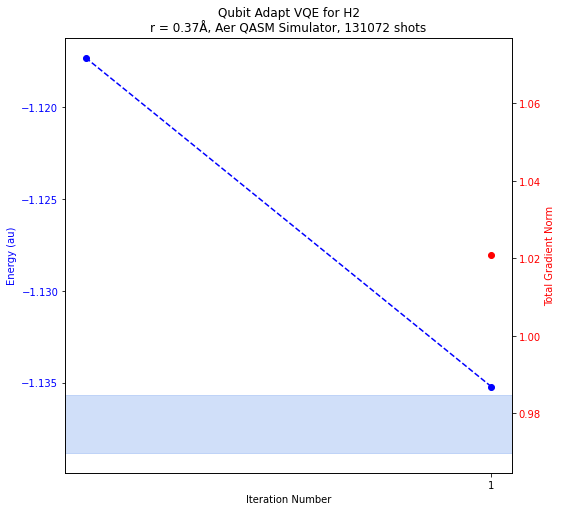

In [ ]:
data.plot()

### Single Iteration

In [ ]:
# Upload evolution dict from computer

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
myFile = open(fn, "rb")
evolution = pickle.load(myFile)

Saving H2_ibmq_belem_iteration1 (1).pkl to H2_ibmq_belem_iteration1 (1) (3).pkl
User uploaded file "H2_ibmq_belem_iteration1 (1).pkl" with length 1396 bytes


In [ ]:
# Use last run

evolution = myAdapt.optEvolution

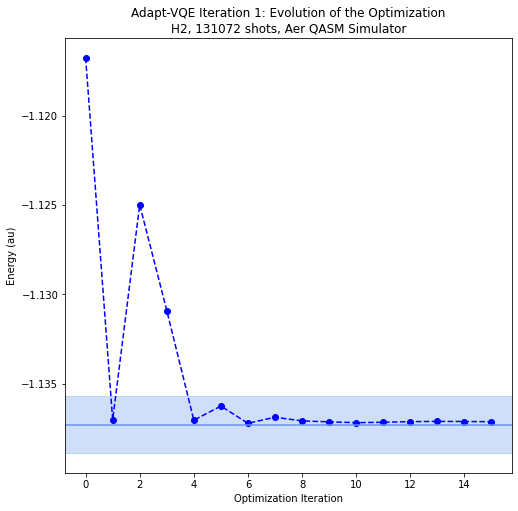

In [ ]:
nfev = evolution["nfev"][-1]
energies = []
for i in range(nfev):
  optimizedCoefficients = list(evolution["parameters"][i])
  energy = myAdapt.calculateEnergy(optimizedCoefficients,data.result["indices"])
  energies.append(energy)

fig, ax1 = plt.subplots(figsize=[8,8])

nfev = evolution["nfev"][-1]

title = "Adapt-VQE Iteration 1: Evolution of the Optimization\n{}, ".format(name)

if backend.name() == "statevector_simulator":
  backendName = "Aer State Vector Simulator"

elif backend.name() == "qasm_simulator":
  backendName = "Aer QASM Simulator"

else:
  backendName = backend.name()

if backendName != "Aer State Vector Simulator":
  title += "{} shots, ".format(myAdapt.shots)
title += "{}".format(backendName)

ax1.set_title(title)

color1 = 'b'
ax1.plot(range(nfev), energies, '--o', color = color1)
ax1.set_xlabel("Optimization Iteration")
ax1.set_ylabel("Energy (au)")

# UCCSD graph scale
#ax1.set_ylim(-1.15,-0.05)

minAccuracy = exactEnergy - chemicalAccuracy
maxAccuracy = exactEnergy + chemicalAccuracy
l = ax1.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

plt.axhline(y = exactEnergy, color = 'cornflowerblue' , linestyle = '-')

### Bond Dissociation Graph

In [ ]:
%%capture

backend = Aer.get_backend('qasm_simulator')
#backend = Aer.get_backend('statevector_simulator')
shots = 2**13
zoom = True
name = molecule.description

threshold = 2.5*10**(-1)
adaptEnergies = []
exactEnergies = []
hfEnergies = []


if zoom:

  if name == "H2":
    start = 0.3
    stop = 0.45
    points = 20
  
  if name == "H4":
    start = 0.7
    stop = 1
    points = 20

else:

  if name == "H2":
    start = 0.1
    stop = 1.1
    points = 50

  if name == "H4":
    start = 0.25
    stop = 2.0
    points = 50

rList = np.linspace(start,stop,points)

for r in rList:

  if name == "H2":
    geometry = [['H',[0,0,0]],['H',[0,0,2*r]]]
    basis = 'sto-3g'
    multiplicity = 1
    charge = 0
    h2 = MolecularData(geometry,basis,multiplicity,charge,description='H2')
    molecule = run_pyscf(h2,run_fci = True,run_ccsd = True)

  if name == "H4":
    geometry = [('H', (0,0,0)), ('H', (0,0,2*r)), ('H', (0,0,4*r)), 
                ('H', (0,0,6*r))]
    basis = 'sto-3g'
    multiplicity = 1
    charge = 0
    h4 = MolecularData(geometry,basis,multiplicity,charge,description='H4')
    molecule = run_pyscf(h4,run_fci = True,run_ccsd = True)

  qinstance = QuantumInstance(backend, 
                              shots = shots)

  myAdapt = AdaptVQE(qubitPool,
                    molecule,
                    qinstance = qinstance,
                    verbose = False,
                    threshold = threshold,
                    maxIterations = 1,
                    shots = shots,
                    referenceDeterminant = None
                    )
  
  myAdapt.prepare()
  myAdapt.run()
  data = myAdapt.data

  hfEnergies.append(data.initialEnergy)
  exactEnergies.append(molecule.fci_energy)
  adaptEnergies.append(data.result["energy"])

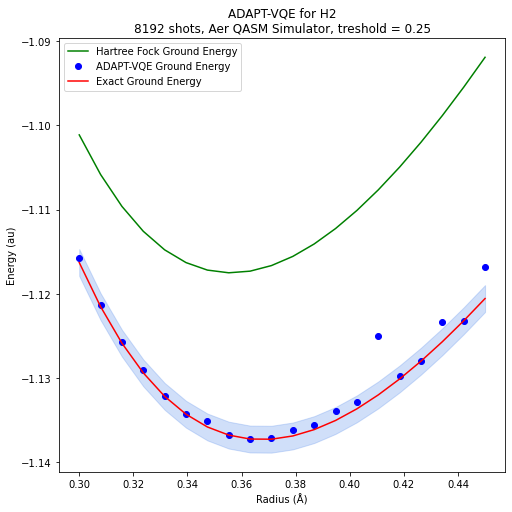

In [ ]:
if backend.name() == "statevector_simulator":
  backendName = "Aer State Vector Simulator"

elif backend.name() == "qasm_simulator":
  backendName = "Aer QASM Simulator"

else:
  backendName = backend.name()

# Change this to plot only part of the data
start = 0
stop = len(rList)

minEnergies = [energy - chemicalAccuracy for energy in exactEnergies][start:stop]
maxEnergies = [energy + chemicalAccuracy for energy in exactEnergies][start:stop]

fig = plt.subplots(figsize = [8,8])

plt.plot(rList[start:stop],hfEnergies[start:stop],color = 'g',label = 'Hartree Fock Ground Energy')
plt.plot(rList[start:stop],adaptEnergies[start:stop],'o',color = 'b',label = 'ADAPT-VQE Ground Energy')
plt.plot(rList[start:stop],exactEnergies[start:stop],color = 'r',label = 'Exact Diagonalization Energy')
plt.fill_between(rList[start:stop],minEnergies,maxEnergies,color='cornflowerblue',alpha=0.3)

plt.ylabel("Energy (au)")
plt.xlabel("Interatomic Distance (Å)")

title = f"ADAPT-VQE for {name}\n"
if backendName != "Aer State Vector Simulator":
  title += "{} shots, ".format(shots)
title += "{}".format(backendName,threshold)

plt.title(title)
plt.legend()

### Error Along Bond Dissociation Graph

Calculate error along bond dissociation graph for H2, along with the number of shots per run per interatomic distance.

In [ ]:
# Obtain number of Pauli strings in the Hamiltonian

hamiltonian = molecule.get_molecular_hamiltonian()
qubitHamiltonian = jordan_wigner(hamiltonian)

qHamiltonianOps = list(qubitHamiltonian.get_operators())

# Create list of Pauli strings in Hamiltonian
hamiltonianStrings = []

for term in qubitHamiltonian.get_operators():

  pauliString = list(term.terms.keys())[0]
  hamiltonianStrings.append(pauliString)


# Get total number of Pauli strings in the Hamiltonian.
# Exclude identity (does not imply measurements)
hamiltonianStringCount = len(hamiltonianStrings)-1
print(hamiltonianStringCount)

14


In [ ]:
# Get total number of Pauli strings in the observables [H,A], that are measured
#to evaluate the gradients.
# If strings are repeated between the Hamiltonian and the operators [H,A], 
#one can recycle measurements. Each string should be included only once in the
#total shot count calculations.

poolMeasStrings = []
totalStrings = 0

for operator in qubitPool:

  observable = qubitHamiltonian*operator - operator*qubitHamiltonian

  for term in observable.get_operators():
    pauliString = list(term.terms.keys())[0]
    totalStrings += 1

    if pauliString not in poolMeasStrings \
    and pauliString not in hamiltonianStrings:
      poolMeasStrings.append(pauliString)

gradientsStringCount = len(poolMeasStrings)

print("Strings that need to be measured to evaluate the gradients"
      " each iteration: ", gradientsStringCount)
print("Total number of strings in the observables (including repeats): "
      ,totalStrings)

Strings that need to be measured to evaluate the gradients each iteration:  24
Total number of strings in the observables (including repeats):  152


In [ ]:
%%capture

# Number of runs over which to take the median and IQR for each point
runs = 10

# Circuit repetitions
shots = int(2**13/1.35)
shots = int(2**13)

medianEnergies = []
exactEnergies = []
totalShots = []
nfevList = []
numberMeasuredObs = []

backend = Aer.get_backend('qasm_simulator')

zoom = True

if zoom:
  start = 0.3
  stop = 0.4
  points = 10

else:
  start = 0.1
  stop = 1.1
  points = 50
  points = 50

rList = np.linspace(start,stop,points)

for r in rList:
  
  geometry = [['H',[0,0,0]],['H',[0,0,2*r]]]
  name = "H2"
  basis = 'sto-3g'
  multiplicity = 1
  charge = 0
  h2 = MolecularData(geometry,basis,multiplicity,charge,description='H2')
  molecule = run_pyscf(h2,run_fci = True,run_ccsd = True)

  finalEnergies = []
  nfevs = []

  for _ in range(runs):

    qinstance = QuantumInstance(backend, 
                                shots = shots)

    myAdapt = AdaptVQE(qubitPool,
                      molecule,
                      qinstance = qinstance,
                      verbose = False,
                      maxIterations = 1,
                      shots = shots,
                      referenceDeterminant = None
                      )
  
    myAdapt.prepare()
    myAdapt.run()
    data = myAdapt.data

    finalEnergies.append(data.result["energy"])

    nfev = myAdapt.optEvolution['nfev'][-1]
    nfevs.append(nfev)

  exactEnergies.append(molecule.fci_energy)

  median = np.median(finalEnergies)
  medianEnergies.append(median)

  # Calculate average number of function evaluations for this interatomic distance
  nfev = np.average(nfevs)

  # Append average number of function evaluations for this interatomic distance
  nfevList.append(nfev)

  # Total number of measured observables
  # = # energy evaluations (nfev) + # operators in pool
  # only 1 iteration here
  measuredObservables = nfev + len(qubitPool)

  numberMeasuredObs.append(measuredObservables)

  # # shots to evaluate the energy =
  # (# energy evaluations) * (# strings in Hamiltonian) * (# shots per string)
  # Only one iteration here, so only one nfev
  energyShots = nfev * hamiltonianStringCount * shots

  # # shots to evaluate the gradients = (# different strings) * (# shots)
  # Again, only one iteration. Would come multiplied by #iter otherwise
  gradientShots = gradientsStringCount * shots
  
  # Add total number of shots used in obtaining the energy for this interatomic
  #distance
  totalShots.append(energyShots + gradientShots)

Text(0.5, 1.0, 'ADAPT-VQE: Error in the Energy\n8192 shots, H2')

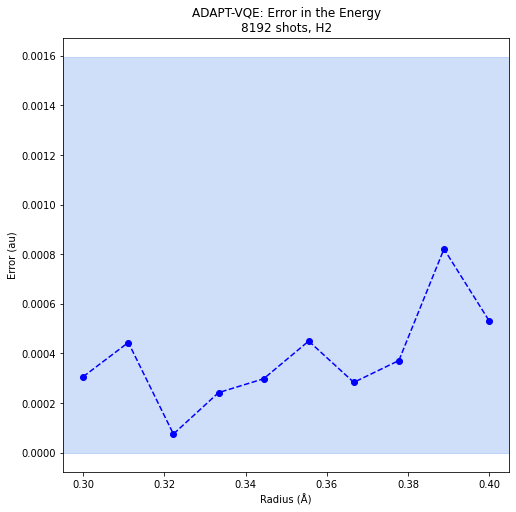

In [ ]:
# Change this to plot only part of the data
start = 0
stop = len(rList)

adaptErrors = [np.abs(medianEnergy - energy) for (medianEnergy, energy) in \
               zip(medianEnergies, exactEnergies)][start:stop]

fig, ax1 = plt.subplots(figsize = [8,8])

ax1.plot(rList[start:stop], 
        adaptErrors[start:stop], 
        '--o',
        color = 'b')

l = ax1.axhspan(0, chemicalAccuracy, alpha=0.3, color = 'cornflowerblue')

ax1.set_ylabel("Error (au)")
ax1.set_xlabel("Interatomic Distance (Å)")

title = f"ADAPT-VQE: Error in the Energy\n"
title += "{} shots, {}".format(shots,name)

ax1.set_title(title)

Text(0.5, 1.0, 'ADAPT-VQE: Measured Observables\n8192 shots, H2')

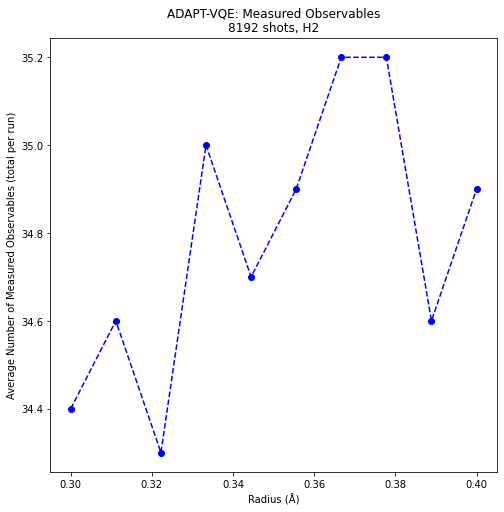

In [ ]:
# Plot average total number of measured observables per run

# Change this to plot only part of the data
start = 0
stop = len(rList)

fig, ax1 = plt.subplots(figsize = [8,8])

ax1.plot(rList[start:stop], 
        numberMeasuredObs[start:stop], 
        '--o',
        color = 'b')

ax1.set_ylabel("Average Number of Measured Observables (total per run)")
ax1.set_xlabel("Interatomic Distance (Å)")

title = f"ADAPT-VQE: Measured Observables\n"
title += "{} shots, {}".format(shots,name)

ax1.set_title(title)

Text(0.5, 1.0, 'ADAPT-VQE: Number of Shots\n8192 shots, H2')

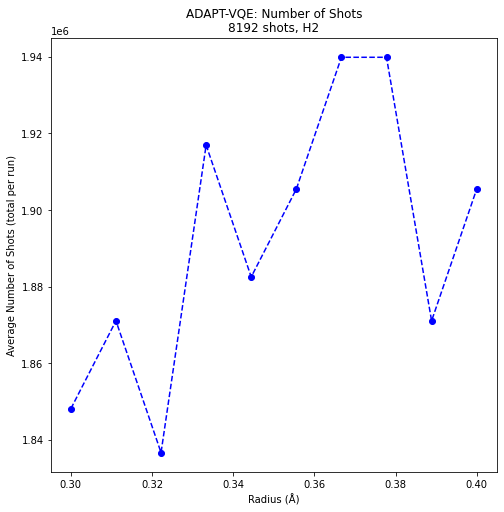

In [ ]:
# Plot average total number of shots per run

# Change this to plot only part of the data
start = 0
stop = len(rList)

fig, ax1 = plt.subplots(figsize = [8,8])

ax1.plot(rList[start:stop], 
        totalShots[start:stop], 
        '--o',
        color = 'b')

ax1.set_ylabel("Average Number of Shots (total per run)")
ax1.set_xlabel("Interatomic Distance (Å)")

title = f"ADAPT-VQE: Number of Shots\n"
title += "{} shots, {}".format(shots,name)

ax1.set_title(title)

Text(0.5, 1.0, 'ADAPT-VQE: Energy Evaluations\n8192 shots, H2')

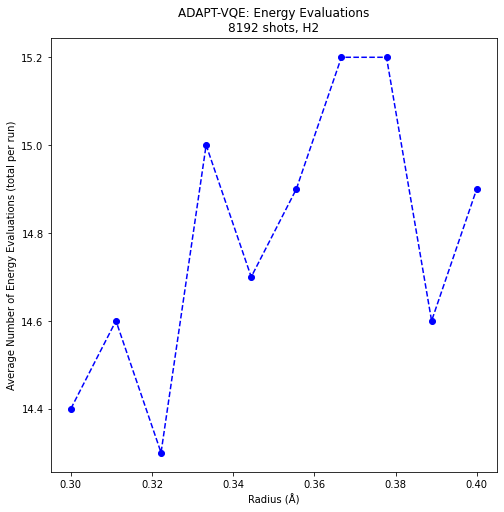

In [ ]:
# Plot average total number of function evaluations per run

# Change this to plot only part of the data
start = 0
stop = len(rList)

fig, ax1 = plt.subplots(figsize = [8,8])

ax1.plot(rList[start:stop], 
        nfevList[start:stop], 
        '--o',
        color = 'b')

ax1.set_ylabel("Average Number of Energy Evaluations (total per run)")
ax1.set_xlabel("Interatomic Distance (Å)")

title = f"ADAPT-VQE: Energy Evaluations\n"
title += "{} shots, {}".format(shots,name)

ax1.set_title(title)

In [ ]:
print(np.average(adaptErrors))

0.00038212834726167875


In [ ]:
fileName = "adapt_analysis2.pkl"
data = (totalShots, nfevList, adaptErrors, numberMeasuredObs)

myFile = open(fileName, "wb")
pickle.dump(data, myFile)
myFile.close()

files.download(fileName) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Upload from computer
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
myFile = open(fn, "rb")
(uccsdtotalShots, uccsdnfevList, uccsdErrors, uccsdnumberMeasuredObs) = pickle.load(myFile)

Saving adapt_analysis.pkl to adapt_analysis.pkl
User uploaded file "adapt_analysis.pkl" with length 997 bytes


Text(0.5, 1.0, 'UCCSD-VQE vs ADAPT-VQE: Error in the Energy (H2)')

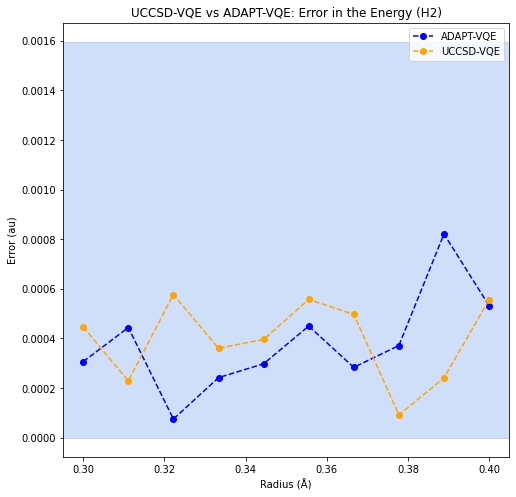

In [ ]:
# Change this to plot only part of the data
start = 0
stop = len(rList)

adaptErrors = [np.abs(medianEnergy - energy) for (medianEnergy, energy) in \
               zip(medianEnergies, exactEnergies)][start:stop]

fig, ax1 = plt.subplots(figsize = [8,8])

ax1.plot(rList[start:stop], 
        adaptErrors[start:stop], 
        '--o',
        color = 'b',
        label = "ADAPT-VQE")

ax1.plot(rList[start:stop], 
        uccsdErrors[start:stop], 
        '--o',
        color = 'orange',
        label = "UCCSD-VQE")

ax1.legend()

l = ax1.axhspan(0, chemicalAccuracy, alpha=0.3, color = 'cornflowerblue')

ax1.set_ylabel("Error (au)")
ax1.set_xlabel("Interatomic Distance (Å)")

title = f"UCCSD-VQE vs ADAPT-VQE: Error in the Energy ({name})"

ax1.set_title(title)

Text(0.5, 1.0, 'UCCSD-VQE vs ADAPT-VQE: Measured Observables (H2)')

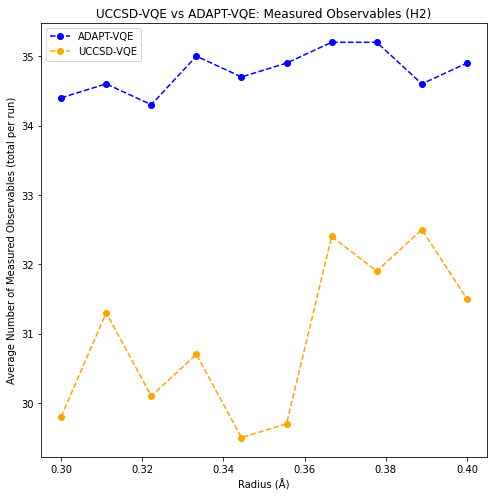

In [ ]:
# Plot average total number of measured observables per run

# Change this to plot only part of the data
start = 0
stop = len(rList)

fig, ax1 = plt.subplots(figsize = [8,8])

ax1.plot(rList[start:stop], 
        numberMeasuredObs[start:stop], 
        '--o',
        color = 'b',
        label = "ADAPT-VQE")

ax1.plot(rList[start:stop], 
        uccsdnumberMeasuredObs[start:stop], 
        '--o',
        color = 'orange',
        label = "UCCSD-VQE")

ax1.legend()

ax1.set_ylabel("Average Number of Measured Observables (total per run)")
ax1.set_xlabel("Interatomic Distance (Å)")

title = f"UCCSD-VQE vs ADAPT-VQE: Measured Observables ({name})"

ax1.set_title(title)

Text(0.5, 1.0, 'UCCSD-VQE vs ADAPT-VQE: Number of Shots (H2)')

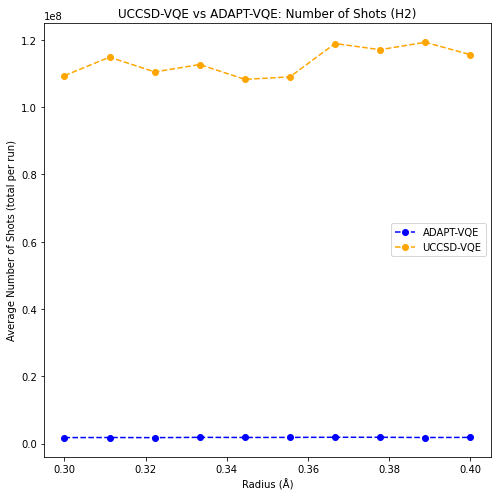

In [ ]:
# Plot average total number of shots per run

# Change this to plot only part of the data
start = 0
stop = len(rList)

fig, ax1 = plt.subplots(figsize = [8,8])

ax1.plot(rList[start:stop], 
        totalShots[start:stop], 
        '--o',
        color = 'b',
        label = "ADAPT-VQE")

ax1.plot(rList[start:stop], 
        uccsdtotalShots[start:stop], 
        '--o',
        color = 'orange',
        label = "UCCSD-VQE")

ax1.legend()

ax1.set_ylabel("Average Number of Shots (total per run)")
ax1.set_xlabel("Interatomic Distance (Å)")

title = f"UCCSD-VQE vs ADAPT-VQE: Number of Shots ({name})"

ax1.set_title(title)

Text(0.5, 1.0, 'UCCSD-VQE vs ADAPT-VQE: Energy Evaluations (H2)')

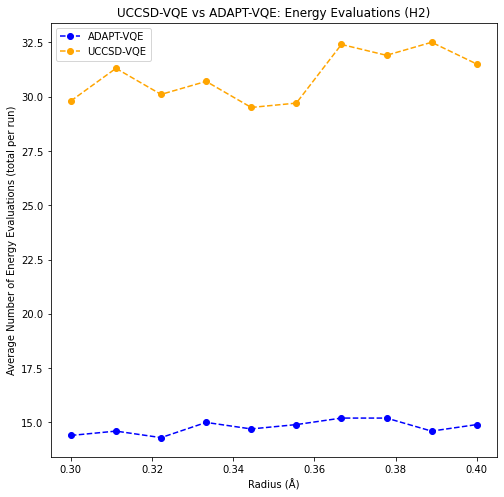

In [ ]:
# Plot average total number of function evaluations per run

# Change this to plot only part of the data
start = 0
stop = len(rList)

fig, ax1 = plt.subplots(figsize = [8,8])

ax1.plot(rList[start:stop], 
        nfevList[start:stop], 
        '--o',
        color = 'b',
        label = "ADAPT-VQE")

ax1.plot(rList[start:stop], 
        uccsdnfevList[start:stop], 
        '--o',
        color = 'orange',
        label = "UCCSD-VQE")

ax1.legend()

ax1.set_ylabel("Average Number of Energy Evaluations (total per run)")
ax1.set_xlabel("Interatomic Distance (Å)")

title = f"UCCSD-VQE vs ADAPT-VQE: Energy Evaluations ({name})"

ax1.set_title(title)

### Sampling 

In [ ]:
%%capture

# Number of runs over which to take the median and IQR for each point
runs = 20

# Circuit repetitions
testShots = [2**i for i in range(5,20,2)] 
testShots = [2**i for i in range(5,14,1)] 

medianEnergies = []
firstQuartiles = []
thirdQuartiles = []

for shots in testShots:
  shots = int(shots)

  energies = []
  
  qinstance = QuantumInstance(backend, 
                              shots = shots)

  finalEnergies = []

  for _ in range(runs):

    myAdapt = AdaptVQE(qubitPool,
                      molecule,
                      qinstance = qinstance,
                      verbose = False,
                      threshold = threshold,
                      maxIterations = maxIterations,
                      shots = shots,
                      referenceDeterminant = None
                      )
    
    myAdapt.prepare()
    myAdapt.run()
    data = myAdapt.data

    finalEnergy = data.result["energy"]
    finalEnergies.append(finalEnergy)

  #runAverage = np.mean(finalEnergies)
  #runSTD = np.std(finalEnergies)
  median = np.median(finalEnergies)
  firstQuartile = median - np.percentile(finalEnergies,25)
  thirdQuartile = np.percentile(finalEnergies,75) - median

  medianEnergies.append(median)
  firstQuartiles.append(firstQuartile)
  thirdQuartiles.append(thirdQuartile)

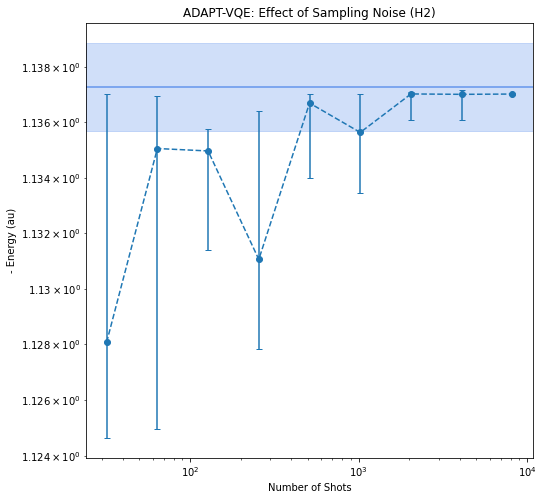

In [ ]:
fig, ax1 = plt.subplots(figsize=[8,8])

title = "ADAPT-VQE: Effect of Sampling Noise ({})".format(name)

ax1.set_title(title)

start = 0
stop = len(testShots)

errors = [energy - exactEnergy for energy in medianEnergies]

ax1.errorbar(testShots[start:stop], 
             #errors[start:stop], 
             #medianEnergies[start:stop],
             #medianEnergies[start:stop],
             [- mE for mE in medianEnergies[start:stop]],
             fmt = '--o',
             # REVERSED beacause of the negative
             yerr = (thirdQuartiles[start:stop],firstQuartiles[start:stop]),
             capsize = 3)

ax1.set_xlabel("Number of Shots")
ax1.set_ylabel("- Energy (au)")
ax1.set_yscale("log")
ax1.set_xscale("log")

caMin = exactEnergy - chemicalAccuracy
caMax = exactEnergy + chemicalAccuracy
#l = ax1.axhspan(caMin,caMax, alpha=0.3, color = 'cornflowerblue')
l = ax1.axhspan(-caMax, -caMin, alpha=0.3, color = 'cornflowerblue')

plt.axhline(y = -exactEnergy, color = 'cornflowerblue' , linestyle = '-')

### Decoherence

In [ ]:
def getDecNoiseModel(t1,t2,measTime,resetTime,cxTime,uTime,qubitNumber,basis_gates):
  '''
  Creates a noise model with decoherence only.
  Must have t2 <= 2t1

  Arguments:
    t1 (float): relaxation time
    t2 (float): dephasing time
    measTime (float): measurement time
    resetTime (float): reset time
    cxTime: 
    qubitNumber (int): the number of qubits of the backend. The error
      will be assumed to apply to all (connected) pairs of qubits.
    basis_gates (list): the basis gates to be assumed in the noise model
  
  Returns:
    noiseModel (qiskit.providers.aer.noise.noise_model.NoiseModel):
      noise model for decoherence
  '''

  noiseModel = NoiseModel(basis_gates=belemNM.basis_gates)

  # Thermal relaxation
  uError = thermal_relaxation_error(t1,t2,uTime)
  measError = thermal_relaxation_error(t1, t2, measTime)
  resetError = thermal_relaxation_error(t1, t2, resetTime)
  cxTError = thermal_relaxation_error(t1, t2, cxTime)
  cxTError = cxTError.tensor(cxTError)

  for i in range(qubitNumber):

    # Add thermal relaxation on each qubit measurement
    noiseModel.add_quantum_error(measError,"measure",[i])
    noiseModel.add_quantum_error(resetError,"reset",[i])

    # Add thermal relaxation on single qubit gates
    noiseModel.add_quantum_error(uError,"id",[i])
    noiseModel.add_quantum_error(uError,"rz",[i])
    noiseModel.add_quantum_error(uError,"x",[i])
    noiseModel.add_quantum_error(uError,"sx",[i])

    # Add thermal relaxation on each possible pair of CNOTs
    for j in range(qubitNumber):
      if j != i:
        noiseModel.add_quantum_error(cxTError,"cx",[i,j])

    return noiseModel

In [ ]:
%%capture

# Number of runs over which to take the average and std for each point
runs = 20

shots = 2**17

# Using IBMQ_Belem data
qubitNumber = 5

# Basic times
# All nanoseconds
t1 = 100E3
t2 = 2*t1

# Times for operations
measTime = 5000 # Measuring
resetTime = 5000 # Reset
cxTime = 500 # CNOT gate
uTime = 100 # Single qubit gate

# Multipliers for t1, t2. 1 = 100%; 2 = 200%; ...
# Will correspond to graph points. 100% of t1, t2; 
#then 200%;...
multipliers = [i/40 for i in range(1,10)]
multipliers = [i/40 for i in range(2,8000,1000)]

medianEnergies = []
firstQuartiles = []
thirdQuartiles = []

for mult in multipliers:
  energies = []
  t1mult = mult * t1
  t2mult = mult * t2

  myNoiseModel = getDecNoiseModel(t1mult,
                                  t2mult,
                                  measTime,
                                  resetTime,
                                  cxTime,
                                  uTime,
                                  qubitNumber,
                                  basis_gates)
  
  qinstance = QuantumInstance(backend, 
                              shots = shots,
                              coupling_map=coupling_map,
                              basis_gates=basis_gates,
                              noise_model=myNoiseModel)

  finalEnergies = []
  
  for _ in range(runs):

    myAdapt = AdaptVQE(qubitPool,
                      molecule,
                      qinstance = qinstance,
                      verbose = False,
                      threshold = threshold,
                      maxIterations = maxIterations,
                      shots = shots,
                      referenceDeterminant = None
                      )
    myAdapt.prepare()
    myAdapt.run()
    data = myAdapt.data

    finalEnergy = data.result["energy"]
    finalEnergies.append(finalEnergy)
    
  median = np.median(finalEnergies)
  firstQuartile = median - np.percentile(finalEnergies,25)
  thirdQuartile = np.percentile(finalEnergies,75) - median

  medianEnergies.append(median)
  firstQuartiles.append(firstQuartile)
  thirdQuartiles.append(thirdQuartile)

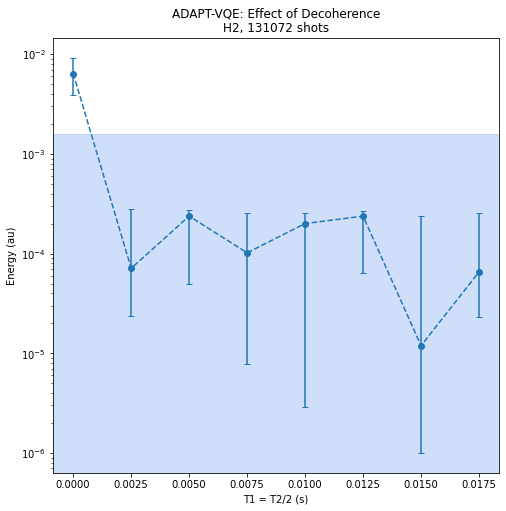

In [ ]:
fig, ax1 = plt.subplots(figsize=[8,8])

title = "ADAPT-VQE: Effect of Decoherence\n{}, ".format(name)
title += "{} shots".format(shots)

ax1.set_title(title)

start = 0
stop = len(multipliers)
times = [multiplier * t1 * 10**(-9) for multiplier in multipliers]

errors = [energy - exactEnergy for energy in medianEnergies]
ax1.errorbar(times[start:stop], 
             errors[start:stop], 
             fmt = '--o',
             yerr = (firstQuartiles[start:stop],thirdQuartiles[start:stop]),
             capsize = 3)


ax1.set_xlabel("T1 = T2/2 (s)")
ax1.set_ylabel("Error (au)")
ax1.set_yscale("log")

minAccuracy = exactEnergy - chemicalAccuracy
maxAccuracy = exactEnergy + chemicalAccuracy
l = ax1.axhspan(0, chemicalAccuracy, alpha=0.3, color = 'cornflowerblue')

plt.axhline(y = exactEnergy, color = 'cornflowerblue' , linestyle = '-')

### Readout Errors

In [ ]:
%%capture

# Number of runs over which to take the median and IQR for each point
runs = 20

# Circuit repetitions
shots = 2**17

# Measure 1 prep 0 average
m1p0 = 0.01 
# Measure 0 prep 1 average
m0p1 = 5 * m1p0

multipliers = [i/10 for i in range(0,21,4)]
#multipliers = [i/10 for i in range(0,40,4)] # ADAPT only

medianEnergies = []
firstQuartiles = []
thirdQuartiles = []

for mult in multipliers:

  energies = []

  # Readout Error
  readoutErrorMatrix = [[1 - m1p0 * mult, m1p0 * mult],
                        [m0p1 * mult, 1 - m0p1 * mult]]
  readoutError = ReadoutError(readoutErrorMatrix)

  noiseModel = NoiseModel()
  for i in range(qubitNumber):
    # Adde readout error on each qubit
    noiseModel.add_readout_error(readoutError,[i])
  
  qinstance = QuantumInstance(backend, 
                              shots = shots,
                              coupling_map=coupling_map,
                              basis_gates=basis_gates,
                              noise_model=noiseModel)

  finalEnergies = []

  for _ in range(runs):

    myAdapt = AdaptVQE(qubitPool,
                      molecule,
                      qinstance = qinstance,
                      verbose = False,
                      threshold = threshold,
                      maxIterations = maxIterations,
                      shots = shots,
                      referenceDeterminant = None
                      )
    myAdapt.prepare()
    myAdapt.run()
    data = myAdapt.data

    finalEnergy = data.result["energy"]
    finalEnergies.append(finalEnergy)

  #runAverage = np.mean(finalEnergies)
  #runSTD = np.std(finalEnergies)
  median = np.median(finalEnergies)
  firstQuartile = median - np.percentile(finalEnergies,25)
  thirdQuartile = np.percentile(finalEnergies,75) - median

  medianEnergies.append(median)
  firstQuartiles.append(firstQuartile)
  thirdQuartiles.append(thirdQuartile)

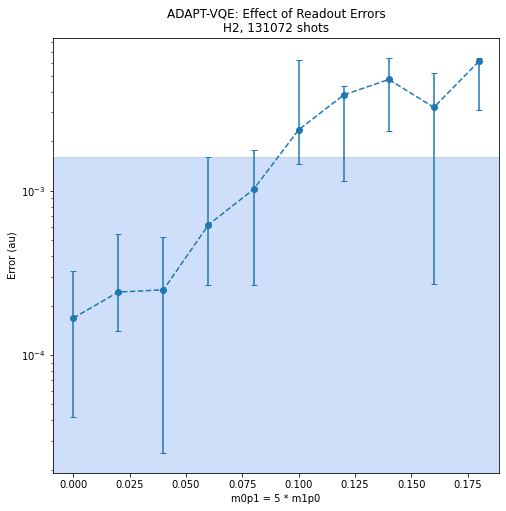

In [ ]:
fig, ax1 = plt.subplots(figsize=[8,8])

title = "ADAPT-VQE: Effect of Readout Errors\n{}, ".format(name)
title += "{} shots".format(shots)

ax1.set_title(title)

start = 0
stop = len(multipliers)
m0p1s = [multiplier * m0p1 for multiplier in multipliers]

errors = [energy - exactEnergy for energy in medianEnergies]
ax1.errorbar(m0p1s[start:stop], 
             errors[start:stop], 
             fmt = '--o',
             yerr = (firstQuartiles[start:stop],thirdQuartiles[start:stop]),
             capsize = 3)


ax1.set_xlabel("m0p1 = 5 * m1p0")
ax1.set_ylabel("Error (au)")
ax1.set_yscale("log")

l = ax1.axhspan(0, chemicalAccuracy, alpha=0.3, color = 'cornflowerblue')

plt.axhline(y = exactEnergy, color = 'cornflowerblue' , linestyle = '-')

### Noise Model

In [ ]:
%%capture

# Number of runs over which to take the average and std for each point
runs = 20

shots = 2**17

# Using IBMQ_Belem data
qubitNumber = 5

# Basic times; t1 is from ibmq_belem
# All nanoseconds
t1 = 86.91E3
t2 = 2*t1

# Measure / CNOT gate times. FrommBelem
measTime = 5351.111
cxTime = 552.889

# Measure 0 prep 1 average
m0p1 = 0.0406
# Measure 1 prep 0 average
m1p0 = 0.0096 


# Multipliers for t1, t2. 1 = 100%; 2 = 200%; ...
# Will correspond to graph points. 100% of t1, t2; 
#then 200%;...
multipliers = [i/5 for i in range(1,12)]
multipliers = [i/5 for i in range(1,2250,200)]

medianEnergies = []
firstQuartiles = []
thirdQuartiles = []

for mult in multipliers:
  energies = []
  t1mult = mult * t1
  t2mult = mult * t2

  myNoiseModel = createNoiseModel(t1mult,t2mult,measTime,cxTime,m0p1,m1p0)
  qinstance = QuantumInstance(backend, 
                              shots = shots,
                              coupling_map=coupling_map,
                              basis_gates=basis_gates,
                              noise_model=myNoiseModel)

  finalEnergies = []
  
  for _ in range(runs):

    myAdapt = AdaptVQE(qubitPool,
                      molecule,
                      qinstance = qinstance,
                      verbose = False,
                      threshold = threshold,
                      maxIterations = maxIterations,
                      shots = shots,
                      referenceDeterminant = None
                      )
    myAdapt.prepare()
    myAdapt.run()
    data = myAdapt.data

    finalEnergy = data.result["energy"]
    finalEnergies.append(finalEnergy)
    
  median = np.median(finalEnergies)
  firstQuartile = median - np.percentile(finalEnergies,25)
  thirdQuartile = np.percentile(finalEnergies,75) - median

  medianEnergies.append(median)
  firstQuartiles.append(firstQuartile)
  thirdQuartiles.append(thirdQuartile)

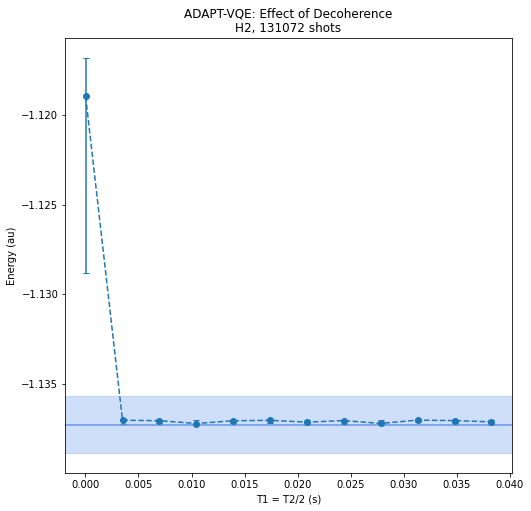

In [ ]:
fig, ax1 = plt.subplots(figsize=[8,8])

title = "ADAPT-VQE: Effect of Decoherence\n{}, ".format(name)
title += "{} shots".format(shots)

ax1.set_title(title)

start = 0
stop = len(multipliers)
times = [multiplier * t1 * 10**(-9) for multiplier in multipliers]
ax1.errorbar(times[start:stop], 
             medianEnergies[start:stop], 
             fmt = '--o',
             yerr = (firstQuartiles[start:stop],thirdQuartiles[start:stop]),
             capsize = 3)


ax1.set_xlabel("T1 = T2/2 (s)")
ax1.set_ylabel("Energy (au)")

minAccuracy = exactEnergy - chemicalAccuracy
maxAccuracy = exactEnergy + chemicalAccuracy
l = ax1.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

plt.axhline(y = exactEnergy, color = 'cornflowerblue' , linestyle = '-')

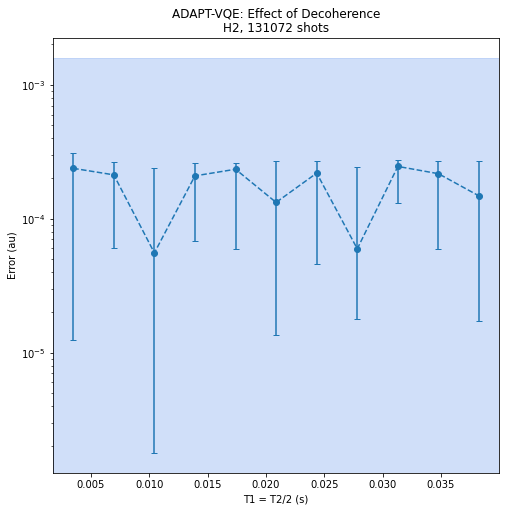

In [ ]:
#errors
#(medianEnergies, firstQuartiles, thirdQuartiles) = data
fig, ax1 = plt.subplots(figsize=[8,8])

title = "ADAPT-VQE: Effect of Decoherence\n{}, ".format(name)
title += "{} shots".format(shots)

ax1.set_title(title)

start = 1
stop = len(multipliers)
times = [multiplier * t1 * 10**(-9) for multiplier in multipliers]

errors = [np.abs(exactEnergy - energy) for energy in medianEnergies]

ax1.errorbar(times[start:stop], 
             #medianEnergies[start:stop], 
             errors[start:stop],
             fmt = '--o',
             yerr = (firstQuartiles[start:stop],thirdQuartiles[start:stop]),
             capsize = 3)


ax1.set_xlabel("T1 = T2/2 (s)")
ax1.set_ylabel("Error (au)")

ax1.set_yscale('log')

minAccuracy = exactEnergy - chemicalAccuracy
maxAccuracy = exactEnergy + chemicalAccuracy
l = ax1.axhspan(0, chemicalAccuracy, alpha=0.3, color = 'cornflowerblue')

## Downloading / Uploading Data to/from File

In [ ]:
fileName = molecule.description + "_" + backend.name() + "_" + str(data.shots) + "_" + str(maxIterations) + ".pkl"
print(fileName)

myFile = open(fileName, "wb")
pickle.dump(data, myFile)
myFile.close()

files.download(fileName) 

In [ ]:
fileName = "adapt_readout.pkl"
data = (medianEnergies, firstQuartiles, thirdQuartiles)

myFile = open(fileName, "wb")
pickle.dump(data, myFile)
myFile.close()

files.download(fileName) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Upload from computer
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
myFile = open(fn, "rb")
data = pickle.load(myFile)

Saving adapt_readout.pkl to adapt_readout (1).pkl
User uploaded file "adapt_readout.pkl" with length 507 bytes
